In [779]:
#Importing necessary dependancies
import pandas as pd
import numpy as np
import ast
from pandas.io.json import json_normalize
import json
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import log_loss
from xgboost import plot_tree

In [589]:
# This block of code is unnecessary(needed for google colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [590]:
train=pd.read_csv("/content/drive/My Drive/train.csv")
test=pd.read_csv("/content/drive/My Drive/test.csv")

# Data Cleaning and Feature Engineering

In [591]:
train.shape,test.shape

((3000, 23), (4398, 22))

In [592]:
train.columns,test.columns

(Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
        'imdb_id', 'original_language', 'original_title', 'overview',
        'popularity', 'poster_path', 'production_companies',
        'production_countries', 'release_date', 'runtime', 'spoken_languages',
        'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
       dtype='object'),
 Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
        'imdb_id', 'original_language', 'original_title', 'overview',
        'popularity', 'poster_path', 'production_companies',
        'production_countries', 'release_date', 'runtime', 'spoken_languages',
        'status', 'tagline', 'title', 'Keywords', 'cast', 'crew'],
       dtype='object'))

In [593]:
train.info(),test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

(None, None)

In [594]:
train.describe()

,id,budget,popularity,runtime,revenue
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,1500.500000,2.253133e+07,8.463274,107.856571,6.672585e+07
std,866.169729,3.702609e+07,12.104000,22.086434,1.375323e+08
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,750.750000,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2250.250000,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09


In [596]:
#Number of missing values in each column  
train.isna().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

#### Genres 

In [597]:
#code block copied from kaggle. Similar code has also been used further. It is to extract information from columns having JSON type values
train.genres=train.genres.fillna('[{}]')

genresList=[]
for index,row in train.genres.iteritems():
    genresStr=''
    listofDict=ast.literal_eval(row)
    for dic in listofDict:
        
        if('name' in dic.keys()):
            genresStr=genresStr+','+dic['name'] 
    genresStr=genresStr.strip(',') # trim leading ,
    genresList.append(genresStr)
    
tempDF=pd.DataFrame(genresList,columns=['genres'])
train.genres=tempDF['genres']

In [598]:
test.genres=test.genres.fillna('[{}]')

genresList=[]
for index,row in test.genres.iteritems():
    genresStr=''
    listofDict=ast.literal_eval(row)
    for dic in listofDict:
        
        if('name' in dic.keys()):
            genresStr=genresStr+','+dic['name'] 
    genresStr=genresStr.strip(',') # trim leading ,
    genresList.append(genresStr)
    
tempDF=pd.DataFrame(genresList,columns=['genres'])
test.genres=tempDF['genres']


In [599]:
train['num_of_genres']=train.genres.apply(lambda x : len(list(x.split(','))) if x != '[{}]' else 0)
#train = train.join(train.genres.str.get_dummies(','))
test['num_of_genres']=test.genres.apply(lambda x : len(list(x.split(','))) if x != '[{}]' else 0)
#test= test.join(test.genres.str.get_dummies(','))

In [600]:
#Finding most common values in the given column and manually doing one hot encoding.Similar method has been employed for further columns
Gen=train['genres'].str.cat(sep=',')
words = Gen.split(",")  
Gen1  = Counter(words).most_common(15)
Gen1
Dum=[]
for i in range(0,15):
  e=Gen1[i][0]
  Dum.append(e)
for gen in Dum:
    train['genre_' + gen] = train['genres'].apply(lambda x: 1 if gen in x else 0)
    test['genre_' + gen] = test['genres'].apply(lambda x: 1 if gen in x else 0)


[('Drama', 1531),
 ('Comedy', 1028),
 ('Thriller', 789),
 ('Action', 741),
 ('Romance', 571),
 ('Crime', 469),
 ('Adventure', 439),
 ('Horror', 301),
 ('Science Fiction', 290),
 ('Family', 260),
 ('Fantasy', 232),
 ('Mystery', 225),
 ('Animation', 141),
 ('History', 132),
 ('Music', 100)]

#### Production Companies

In [603]:
train.production_companies=train.production_companies.fillna('[{}]')

List=[]
for index,row in train.production_companies.iteritems():
    Str=''
    listofDict=ast.literal_eval(row)
    for dic in listofDict:
        
        if('name' in dic.keys()):
            Str=Str+','+dic['name'] 
    Str=Str.strip(',') # trim leading ,
    List.append(Str)
    
tempDF=pd.DataFrame(List,columns=['production_companies'])
train.production_companies=tempDF['production_companies']

In [604]:
test.production_companies=test.production_companies.fillna('[{}]')

List=[]
for index,row in test.production_companies.iteritems():
    Str=''
    listofDict=ast.literal_eval(row)
    for dic in listofDict:
        
        if('name' in dic.keys()):
            Str=Str+','+dic['name'] 
    Str=Str.strip(',') # trim leading ,
    List.append(Str)
    
tempDF=pd.DataFrame(List,columns=['production_companies'])
test.production_companies=tempDF['production_companies']


train['num_of_productioncompanies']=train.production_companies.apply(lambda x : len(list(x.split(','))) if x != '[{}]' else 0)
#train = train.join(train.production_companies.str.get_dummies(','))

test['num_of_productioncompanies']=test.production_companies.apply(lambda x : len(list(x.split(','))) if x != '[{}]' else 0)
#test= test.join(test.production_companies.str.get_dummies(','))

In [605]:
Com=train['production_companies'].str.cat(sep=',')
words = Com.split(",")  
Com1  = Counter(words).most_common(15)
Dum=[]
for i in range(0,15):
  e=Com1[i][0]
  Dum.append(e)
for com in Dum:
    train['Company_' + com] = train['production_companies'].apply(lambda x: 1 if com in x else 0)
    test['Company_' + com] = test['production_companies'].apply(lambda x: 1 if com in x else 0)

#### Production_Countries

In [606]:
train.production_countries=train.production_countries.fillna('[{}]')

List=[]
for index,row in train.production_countries.iteritems():
    Str=''
    listofDict=ast.literal_eval(row)
    for dic in listofDict:
        
        if('name' in dic.keys()):
            Str=Str+','+dic['name'] 
    Str=Str.strip(',') # trim leading ,
    List.append(Str)
    
tempDF=pd.DataFrame(List,columns=['production_countries'])
train.production_countries=tempDF['production_countries']

In [607]:
test.production_countries=test.production_countries.fillna('[{}]')

List=[]
for index,row in test.production_countries.iteritems():
    Str=''
    listofDict=ast.literal_eval(row)
    for dic in listofDict:
        
        if('name' in dic.keys()):
            Str=Str+','+dic['name'] 
    Str=Str.strip(',') # trim leading ,
    List.append(Str)
    
tempDF=pd.DataFrame(List,columns=['production_countries'])
test.production_countries=tempDF['production_countries']

In [608]:
train['num_of_productioncountries']=train.production_countries.apply(lambda x : len(list(x.split(','))) if x != '[{}]' else 0)
test['num_of_productioncountries']=test.production_countries.apply(lambda x : len(list(x.split(','))) if x != '[{}]' else 0)
#train = train.join(train.production_countries.str.get_dummies(','))
#test = test.join(test.production_countries.str.get_dummies(','))



In [609]:
Cou=train['production_countries'].str.cat(sep=',')
words = Cou.split(",")  
Cou1  = Counter(words).most_common(15)
Dum=[]
for i in range(0,15):
  e=Cou1[i][0]
  Dum.append(e)
for cou in Dum:
    train['Country_' + cou] = train['production_countries'].apply(lambda x: 1 if cou in x else 0)
    test['Country_' + cou] = test['production_countries'].apply(lambda x: 1 if cou in x else 0)

#### Spoken_Languages

In [610]:
train.spoken_languages=train.spoken_languages.fillna('[{}]')

List=[]
for index,row in train.spoken_languages.iteritems():
    Str=''
    listofDict=ast.literal_eval(row)
    for dic in listofDict:
        
        if('name' in dic.keys()):
            Str=Str+','+dic['name'] 
    Str=Str.strip(',') # trim leading ,
    List.append(Str)
    
tempDF=pd.DataFrame(List,columns=['spoken_languages'])
train.spoken_languages=tempDF['spoken_languages']

In [611]:
test.spoken_languages=test.spoken_languages.fillna('[{}]')

List=[]
for index,row in test.spoken_languages.iteritems():
    Str=''
    listofDict=ast.literal_eval(row)
    for dic in listofDict:
        
        if('name' in dic.keys()):
            Str=Str+','+dic['name'] 
    Str=Str.strip(',') # trim leading ,
    List.append(Str)
    
tempDF=pd.DataFrame(List,columns=['spoken_languages'])
test.spoken_languages=tempDF['spoken_languages']


train['num_of_spokenlanguages']=train.spoken_languages.apply(lambda x : len(list(x.split(','))) if x != '[{}]' else 0)
#train = train.join(train.spoken_languages.str.get_dummies(','))

test['num_of_spokenlanguages']=test.spoken_languages.apply(lambda x : len(list(x.split(','))) if x != '[{}]' else 0)
#test= test.join(test.spoken_languages.str.get_dummies(','))

In [612]:
Lan=train['spoken_languages'].str.cat(sep=',')
words = Lan.split(",")  
Lan1  = Counter(words).most_common(15)
Dum=[]
for i in range(0,15):
  e=Lan1[i][0]
  Dum.append(e)
for lan in Dum:
    train['Language_' + lan] = train['spoken_languages'].apply(lambda x: 1 if lan in x else 0)
    test['Language_' + lan] = test['spoken_languages'].apply(lambda x: 1 if lan in x else 0)

#### keywords

In [613]:
train.Keywords=train.Keywords.fillna('[{}]')

List=[]
for index,row in train.Keywords.iteritems():
    Str=''
    listofDict=ast.literal_eval(row)
    for dic in listofDict:
        
        if('name' in dic.keys()):
            Str=Str+','+dic['name'] 
    Str=Str.strip(',') # trim leading ,
    List.append(Str)
    
tempDF=pd.DataFrame(List,columns=['Keywords'])
train.Keywords=tempDF['Keywords']

In [614]:
test.Keywords=test.Keywords.fillna('[{}]')

List=[]
for index,row in test.Keywords.iteritems():
    Str=''
    listofDict=ast.literal_eval(row)
    for dic in listofDict:
        
        if('name' in dic.keys()):
            Str=Str+','+dic['name'] 
    Str=Str.strip(',') # trim leading ,
    List.append(Str)
    
tempDF=pd.DataFrame(List,columns=['Keywords'])
test.Keywords=tempDF['Keywords']

train['num_of_keywords']=train.Keywords.apply(lambda x : len(list(x.split(','))) if x != '[{}]' else 0)
test['num_of_keywords']=test.Keywords.apply(lambda x : len(list(x.split(','))) if x != '[{}]' else 0)

In [615]:
key=train['Keywords'].str.cat(sep=',')
words = key.split(",")  
key1  = Counter(words).most_common(15)
Dum=[]
for i in range(0,15):
  e=key1[i][0]
  Dum.append(e)
for Key in Dum:
    train['Keyword_' + Key] = train['Keywords'].apply(lambda x: 1 if Key in x else 0)
    test['Keyword_' + Key] = test['Keywords'].apply(lambda x: 1 if Key in x else 0)

#### Cast

In [616]:
#Avoid this code

#train.cast=train.cast.fillna('[{}]')

#List=[]
#for index,row in train.cast.iteritems():
    #Str=''
    #listofDict=ast.literal_eval(row)
    #for dic in listofDict:
        
        #if('name' in dic.keys()):
            #string=str(dic['gender'])
            #Str=Str+','+string
    #Str=Str.strip(',') # trim leading ,
    #List.append(Str)
    #print(List)
    
#tempDF=pd.DataFrame(List,columns=['Gender'])
#train['Gender']=tempDF['Gender']
#train = train.join(train.Gender.str.get_dummies(','))

In [617]:
train.cast=train.cast.fillna('[{}]')

List=[]
for index,row in train.cast.iteritems():
    Str=''
    listofDict=ast.literal_eval(row)
    for dic in listofDict:
        
        if('name' in dic.keys()):
            Str=Str+','+dic['name'] 
    Str=Str.strip(',') # trim leading ,
    List.append(Str)
    
tempDF=pd.DataFrame(List,columns=['cast'])
train.cast=tempDF['cast']

In [618]:
test.cast=test.cast.fillna('[{}]')

List=[]
for index,row in test.cast.iteritems():
    Str=''
    listofDict=ast.literal_eval(row)
    for dic in listofDict:
        
        if('name' in dic.keys()):
            Str=Str+','+dic['name'] 
    Str=Str.strip(',') # trim leading ,
    List.append(Str)
    
tempDF=pd.DataFrame(List,columns=['cast'])
test.cast=tempDF['cast']

In [619]:
train['total_castmembers']=train.cast.apply(lambda x : len(list(x.split(','))) if x != '[{}]' else 0)
test['total_castmembers']=test.cast.apply(lambda x : len(list(x.split(','))) if x != '[{}]' else 0)

#### Crew

In [620]:
train.crew=train.crew.fillna('[{}]')

List=[]
for index,row in train.crew.iteritems():
    Str=''
    listofDict=ast.literal_eval(row)
    for dic in listofDict:
        
        if('name' in dic.keys()):
            Str=Str+','+dic['name'] 
    Str=Str.strip(',') # trim leading ,
    List.append(Str)
    
tempDF=pd.DataFrame(List,columns=['crew_members'])
train['crew_members']=tempDF['crew_members']

In [621]:
test.crew=test.crew.fillna('[{}]')

List=[]
for index,row in test.crew.iteritems():
    Str=''
    listofDict=ast.literal_eval(row)
    for dic in listofDict:
        
        if('name' in dic.keys()):
            Str=Str+','+dic['name'] 
    Str=Str.strip(',') # trim leading ,
    List.append(Str)
    
tempDF=pd.DataFrame(List,columns=['crew_members'])
test['crew_members']=tempDF['crew_members']

train['total_crew_members']=train.crew_members.apply(lambda x : len(list(x.split(','))) if x != '[{}]' else 0)
test['total_crew_members']=test.crew_members.apply(lambda x : len(list(x.split(','))) if x != '[{}]' else 0)


In [622]:
List=[]
for index,row in train.crew.iteritems():
    Str=''
    listofDict=ast.literal_eval(row)
    for dic in listofDict:
        
        if('department' in dic.keys()):
            Str=Str+','+dic['department'] 
    Str=Str.strip(',') # trim leading ,
    List.append(Str)
    
tempDF=pd.DataFrame(List,columns=['crew_department'])
train['crew_department']=tempDF['crew_department']

In [623]:
List=[]
for index,row in test.crew.iteritems():
    Str=''
    listofDict=ast.literal_eval(row)
    for dic in listofDict:
        
        if('department' in dic.keys()):
            Str=Str+','+dic['department'] 
    Str=Str.strip(',') # trim leading ,
    List.append(Str)
    
tempDF=pd.DataFrame(List,columns=['crew_department'])
test['crew_department']=tempDF['crew_department']

In [624]:
List=[]
for index,row in train.crew.iteritems():
    Str=''
    listofDict=ast.literal_eval(row)
    for dic in listofDict:
        
        if('job' in dic.keys()):
            Str=Str+','+dic['job'] 
    Str=Str.strip(',') # trim leading ,
    List.append(Str)
    
tempDF=pd.DataFrame(List,columns=['crew_job'])
train['crew_job']=tempDF['crew_job']

In [625]:
List=[]
for index,row in test.crew.iteritems():
    Str=''
    listofDict=ast.literal_eval(row)
    for dic in listofDict:
        
        if('job' in dic.keys()):
            Str=Str+','+dic['job'] 
    Str=Str.strip(',') # trim leading ,
    List.append(Str)
    
tempDF=pd.DataFrame(List,columns=['crew_job'])
test['crew_job']=tempDF['crew_job']

In [626]:
#bro= train['crew_department'].str.get_dummies(',')
#bro.drop(['Crew'],axis=1,inplace=True)
#train=train.join(bro)
#bro1=test['crew_department'].str.get_dummies(',')
#bro1.drop(['Crew'],axis=1,inplace=True)
#test=test.join(bro1)
#bro2=train['crew_job'].str.get_dummies(',')
#bro2columns= bro2.columns
#for i in bro2columns:
    #bro2.rename(columns={i: 'job'+i}, inplace=True)
#train=train.join(bro2)
#bro3=test['crew_job'].str.get_dummies(',')
#bro3columns= bro3.columns
#for i in bro3columns:
    #bro3.rename(columns={i: 'job'+i}, inplace=True)
#test=test.join(bro3)


In [627]:
dep=train['crew_department'].str.cat(sep=',')
words = dep.split(",")  
dep1  = Counter(words).most_common(10)
dep1
Dum=[]
for i in range(0,10):
  e=dep1[i][0]
  Dum.append(e)
for Dep in Dum:
    train['Department_' + Dep] = train['crew_department'].apply(lambda x: 1 if Dep in x else 0)
    test['Department_' + Dep] = test['crew_department'].apply(lambda x: 1 if Dep in x else 0)



In [628]:
Job=train['crew_job'].str.cat(sep=',')
words = Job.split(",")  
Job1  = Counter(words).most_common(15)
Job1
Dum=[]
for i in range(0,15):
  e=Job1[i][0]
  Dum.append(e)
for job in Dum:
    train['Job_' + job] = train['crew_job'].apply(lambda x: 1 if job in x else 0)
    test['Job_' + job] = test['crew_job'].apply(lambda x: 1 if job in x else 0)



#### Belongs_to_Collection

In [629]:
train.belongs_to_collection=train.belongs_to_collection.fillna('[{}]')

train.belongs_to_collection=train.belongs_to_collection.apply(lambda x: 1 if x != '[{}]' else 0 )

In [630]:
test.belongs_to_collection=test.belongs_to_collection.fillna('[{}]')

test.belongs_to_collection=test.belongs_to_collection.apply(lambda x: 1 if x != '[{}]' else 0 )

#### Homepage

In [631]:
train.homepage=train.homepage.fillna('[{}]')

train.homepage=train.homepage.apply(lambda x: 1 if x != '[{}]' else 0 )

test.homepage=test.homepage.fillna('[{}]')

test.homepage=test.homepage.apply(lambda x: 1 if x != '[{}]' else 0 )

#### Release Date

In [632]:
#Seperating the date, day and year column
train['release_date'] = pd.to_datetime(train['release_date'])
train.loc[train['release_date'].dt.year >= 2020, 'release_date'] -= pd.DateOffset(years=100)
train['Year'], train['Month'],train['Date'] = train['release_date'].dt.year, train['release_date'].dt.month,train['release_date'].dt.day


In [633]:
test = test[test['release_date'].notnull()]

In [634]:
test['release_date'] = pd.to_datetime(test['release_date'])
test.loc[test['release_date'].dt.year >= 2020, 'release_date'] -= pd.DateOffset(years=100)
test['Year'], test['Month'],test['Date'] = test['release_date'].dt.year, test['release_date'].dt.month,test['release_date'].dt.day


In [635]:
train['First_Quarter_Release']=train.Month.apply(lambda x: 1 if x <= 3 else 0)
train['Second_Quarter_Release']=train.Month.apply(lambda x: 1 if x <= 6 and x > 3 else 0)
train['Third_Quarter_Release']=train.Month.apply(lambda x: 1 if x <= 9 and x > 6 else 0)
train['Fourth_Quarter_Release']=train.Month.apply(lambda x: 1 if x <= 12 and x > 9 else 0)

In [636]:
test['First_Quarter_Release']=test.Month.apply(lambda x: 1 if x <= 3 else 0)
test['Second_Quarter_Release']=test.Month.apply(lambda x: 1 if x <= 6 and x > 3 else 0)
test['Third_Quarter_Release']=test.Month.apply(lambda x: 1 if x <= 9 and x > 6 else 0)
test['Fourth_Quarter_Release']=test.Month.apply(lambda x: 1 if x <= 12 and x > 9 else 0)

#### Text Columns

In [637]:
#This block of code has been copid from kaggle notebook by Andrew Lukyan

for col in ['title', 'tagline', 'overview', 'original_title']:
    train['len_' + col] = train[col].fillna('').apply(lambda x: len(str(x)))
    train['words_' + col] = train[col].fillna('').apply(lambda x: len(str(x.split(' '))))
    test['len_' + col] = test[col].fillna('').apply(lambda x: len(str(x)))
    test['words_' + col] = test[col].fillna('').apply(lambda x: len(str(x.split(' '))))

## Exploratory Data Analysis

#### Budget

In [640]:
#plotting different features vs target values
Budget=train.budget.value_counts().to_frame()

In [641]:
Budget.rename(columns={'budget':'Value_Counts'},inplace=True)

In [642]:
Budget.index.name = 'Budget'
Budget.reset_index()

,Budget,Value_Counts
0,0,812
1,15000000,72
2,40000000,71
3,25000000,71
4,20000000,68
...,...,...
401,3750000,1
402,113,1
403,891000,1
404,5400000,1


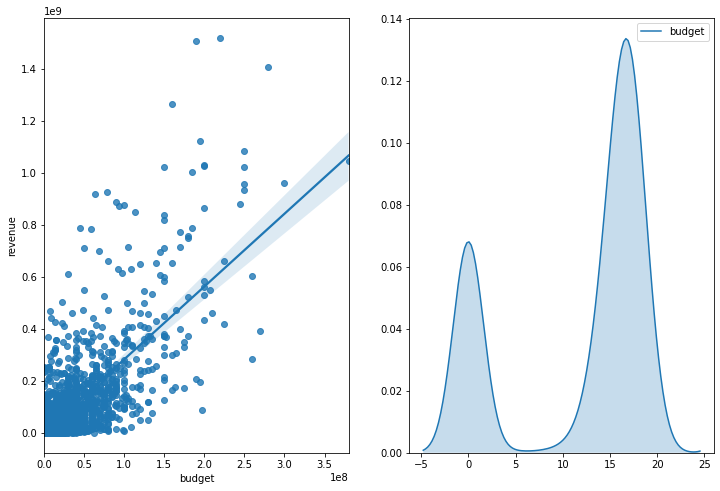

In [643]:
plt.figure(figsize=(12,8))
ax1  = plt.subplot(1,2,1)
sns.regplot(x="budget", y="revenue", data=train)

ax2  = plt.subplot(1,2,2)
sns.kdeplot(np.log1p(train['budget']), shade=True)
plt.legend()

plt.show()


#### Genre

In [644]:
#list(train.columns.values.tolist()) 

In [645]:
Genres=['genre_Drama','genre_Comedy','genre_Thriller','genre_Action','genre_Romance','genre_Crime','genre_Adventure','genre_Horror','genre_Science Fiction','genre_Family','genre_Fantasy','genre_Mystery','genre_Animation','genre_History','genre_Music']

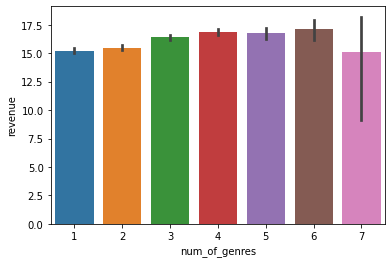

In [646]:
sns.barplot(train['num_of_genres'],np.log1p(train['revenue']))

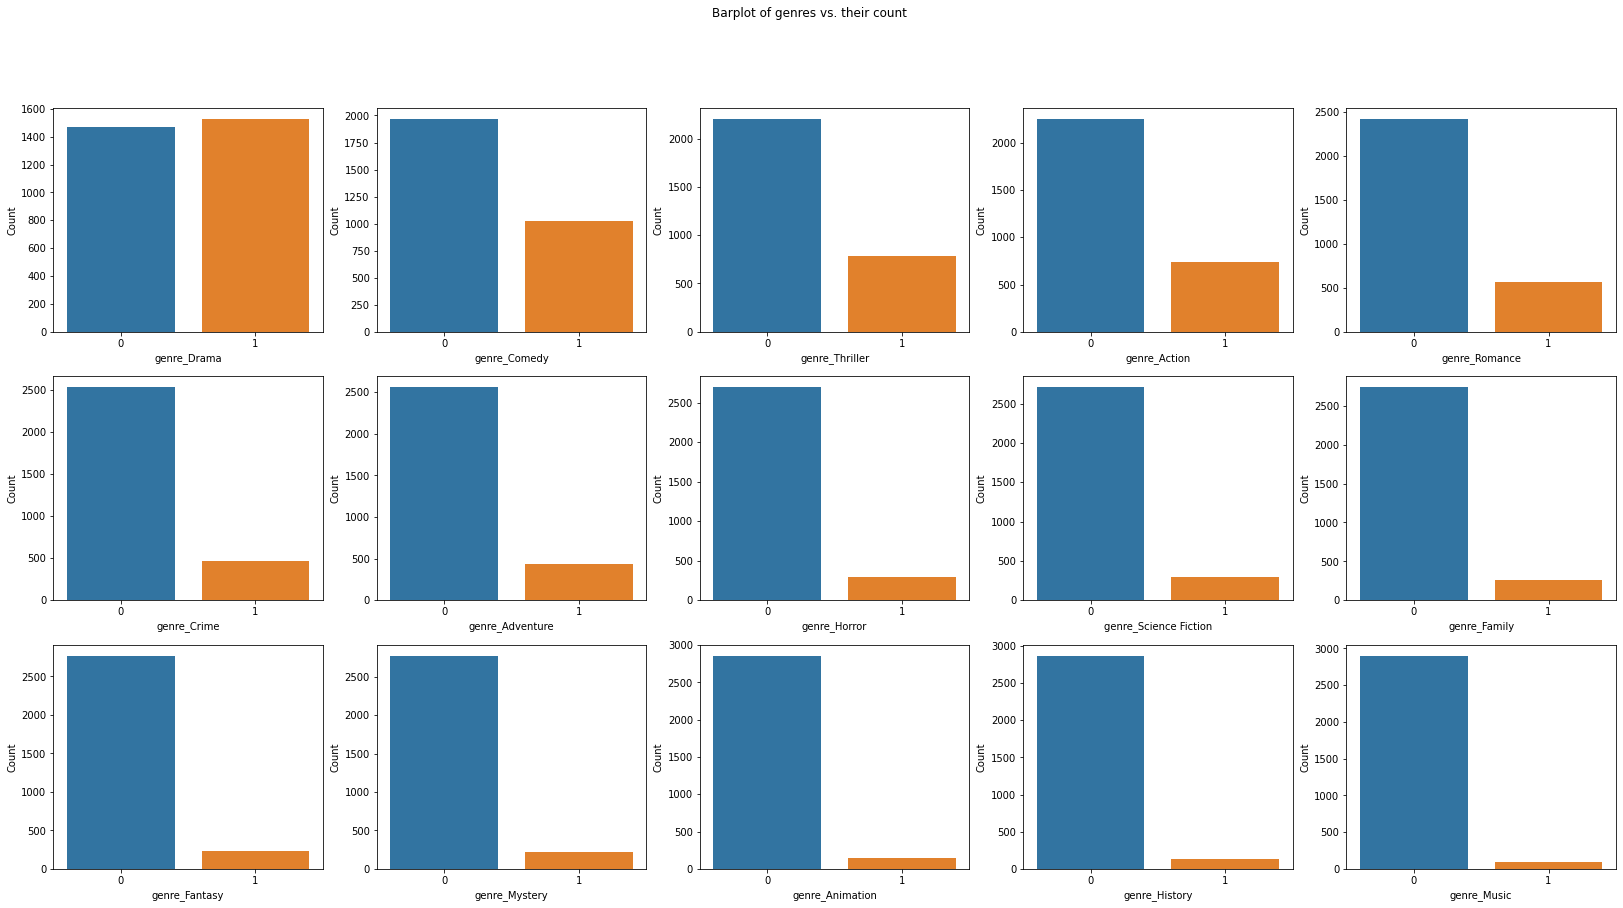

In [647]:
f, axes = plt.subplots(3, 5, figsize=(28, 14))
plt.suptitle('Barplot of genres vs. their count')
for i, e in enumerate(Genres):
    Gr=train.groupby([e],as_index=False)['id'].count()
    Gr.rename(columns={'id':'Count'},inplace=True)
    sns.barplot(data=Gr, x=e, y = "Count", ax=axes[i //5 ][i % 5 ])
    
    


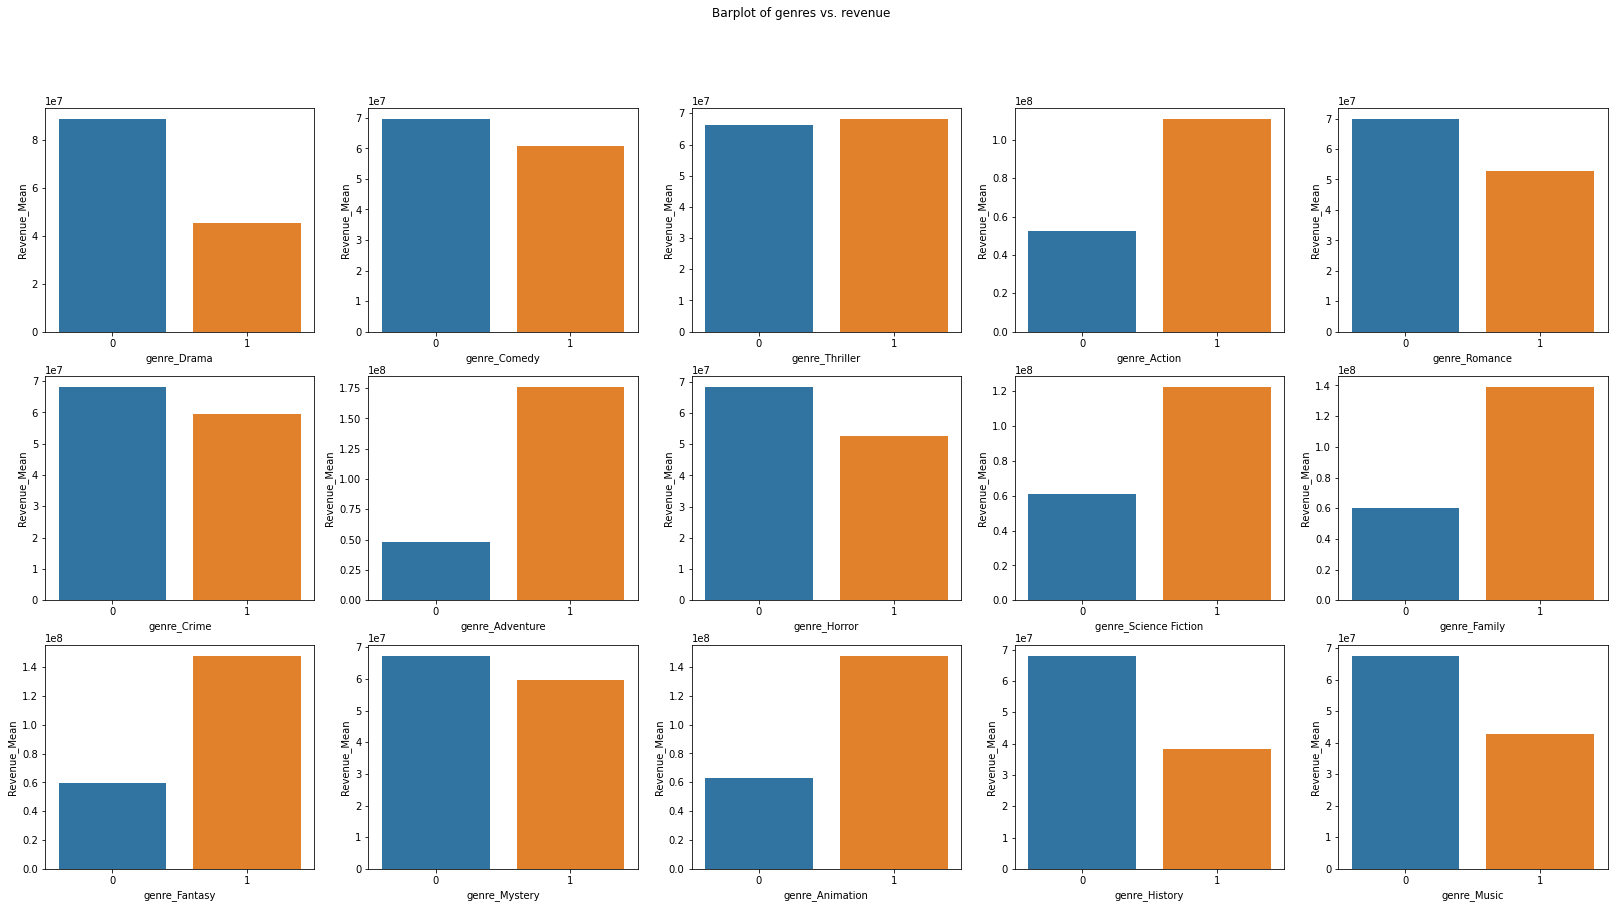

In [648]:
f, axes = plt.subplots(3, 5, figsize=(28, 14))
plt.suptitle('Barplot of genres vs. revenue')
for i, e in enumerate(Genres):
    Gr=train.groupby([e],as_index=False)['revenue'].mean()
    Gr.rename(columns={'revenue':'Revenue_Mean'},inplace=True)
    sns.barplot(data=Gr, x=e, y = "Revenue_Mean", ax=axes[i //5 ][i % 5 ])

#### Homepage

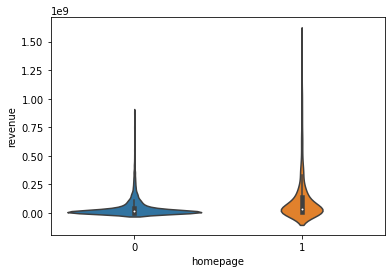

In [649]:
sns.violinplot(data=train, x='homepage', y = "revenue")

#### Overview

In [650]:
stopwords = set(STOPWORDS)

In [651]:
Overview= ' '.join(train['overview'].fillna('').values)

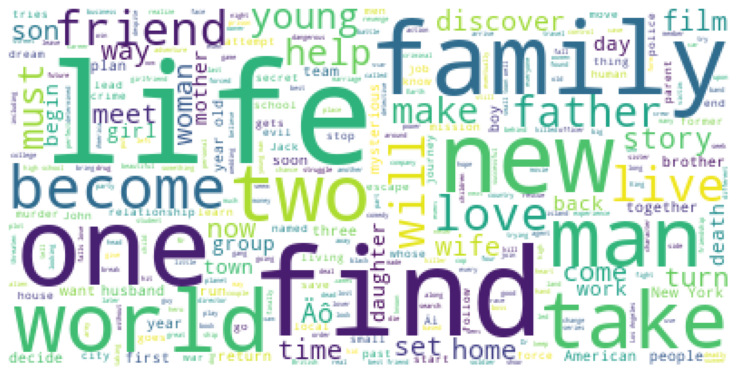

In [652]:
plt.figure(figsize =(13,13))
ov_wc = WordCloud(
    background_color='white',
    max_words=500,
    stopwords=stopwords
)

# generate the word cloud
ov_wc.generate(Overview)
plt.imshow(ov_wc)
plt.axis('off')
plt.show()

#### Popularity

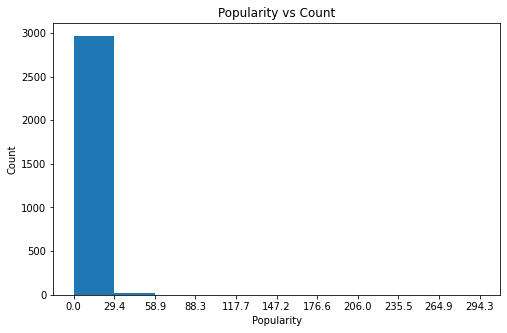

In [653]:
count, bin_edges = np.histogram(train['popularity'])

train['popularity'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges)
plt.title("Popularity vs Count")
plt.xlabel("Popularity")
plt.ylabel("Count")

plt.show()

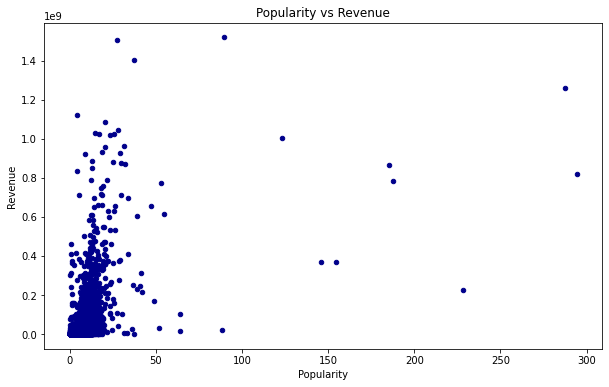

In [654]:
train.plot(kind='scatter', x='popularity', y='revenue', figsize=(10, 6), color='darkblue')

plt.title('Popularity vs Revenue')
plt.xlabel('Popularity')
plt.ylabel('Revenue')

plt.show()

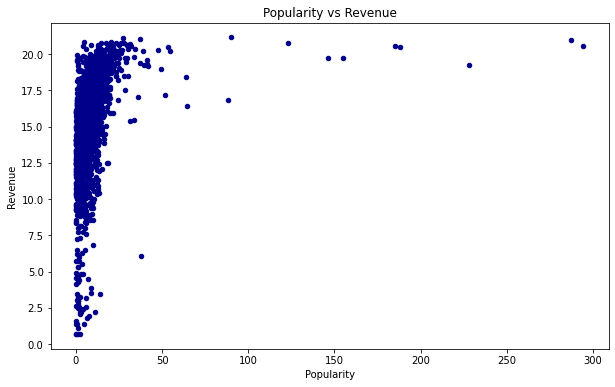

In [655]:
train['log_revenue']=np.log1p(train['revenue'])
train.plot(kind='scatter', x='popularity', y='log_revenue', figsize=(10, 6), color='darkblue')

plt.title('Popularity vs Revenue')
plt.xlabel('Popularity')
plt.ylabel('Revenue')

plt.show()

#### Number of production Companies

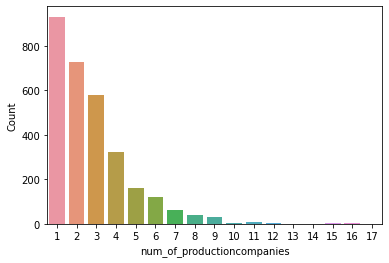

In [656]:
PC=train.groupby(['num_of_productioncompanies'],as_index=False)['id'].count()
PC.rename(columns={'id':'Count'},inplace=True)
sns.barplot(data=PC, x='num_of_productioncompanies', y = "Count")

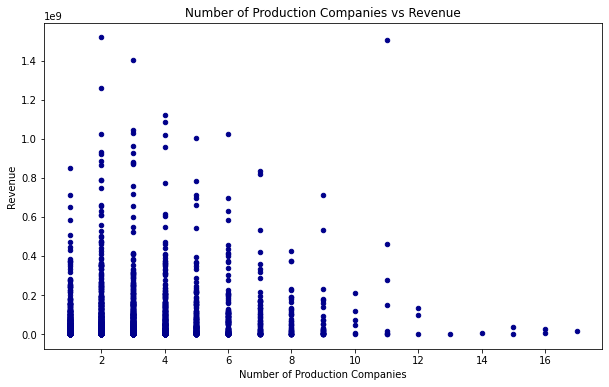

In [657]:
train.plot(kind='scatter', x='num_of_productioncompanies', y='revenue', figsize=(10, 6), color='darkblue')

plt.title('Number of Production Companies vs Revenue')
plt.xlabel('Number of Production Companies')
plt.ylabel('Revenue')

plt.show()

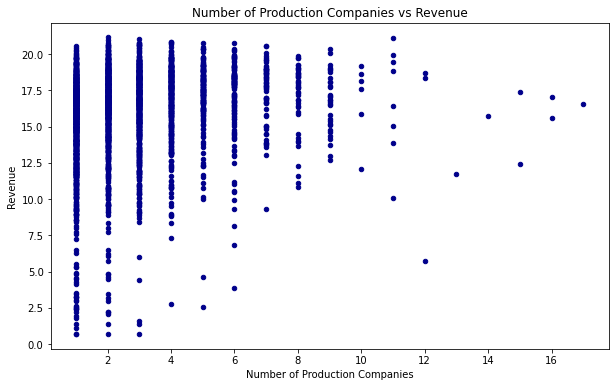

In [658]:
train.plot(kind='scatter', x='num_of_productioncompanies', y='log_revenue', figsize=(10, 6), color='darkblue')

plt.title('Number of Production Companies vs Revenue')
plt.xlabel('Number of Production Companies')
plt.ylabel('Revenue')

plt.show()

In [659]:
Companies=['Company_Warner Bros.','Company_Universal Pictures','Company_Paramount Pictures','Company_','Company_Twentieth Century Fox Film Corporation','Company_Columbia Pictures','Company_Metro-Goldwyn-Mayer (MGM)','Company_New Line Cinema','Company_Touchstone Pictures','Company_Walt Disney Pictures','Company_Columbia Pictures Corporation','Company_TriStar Pictures','Company_Relativity Media','Company_Canal+','Company_United Artists']

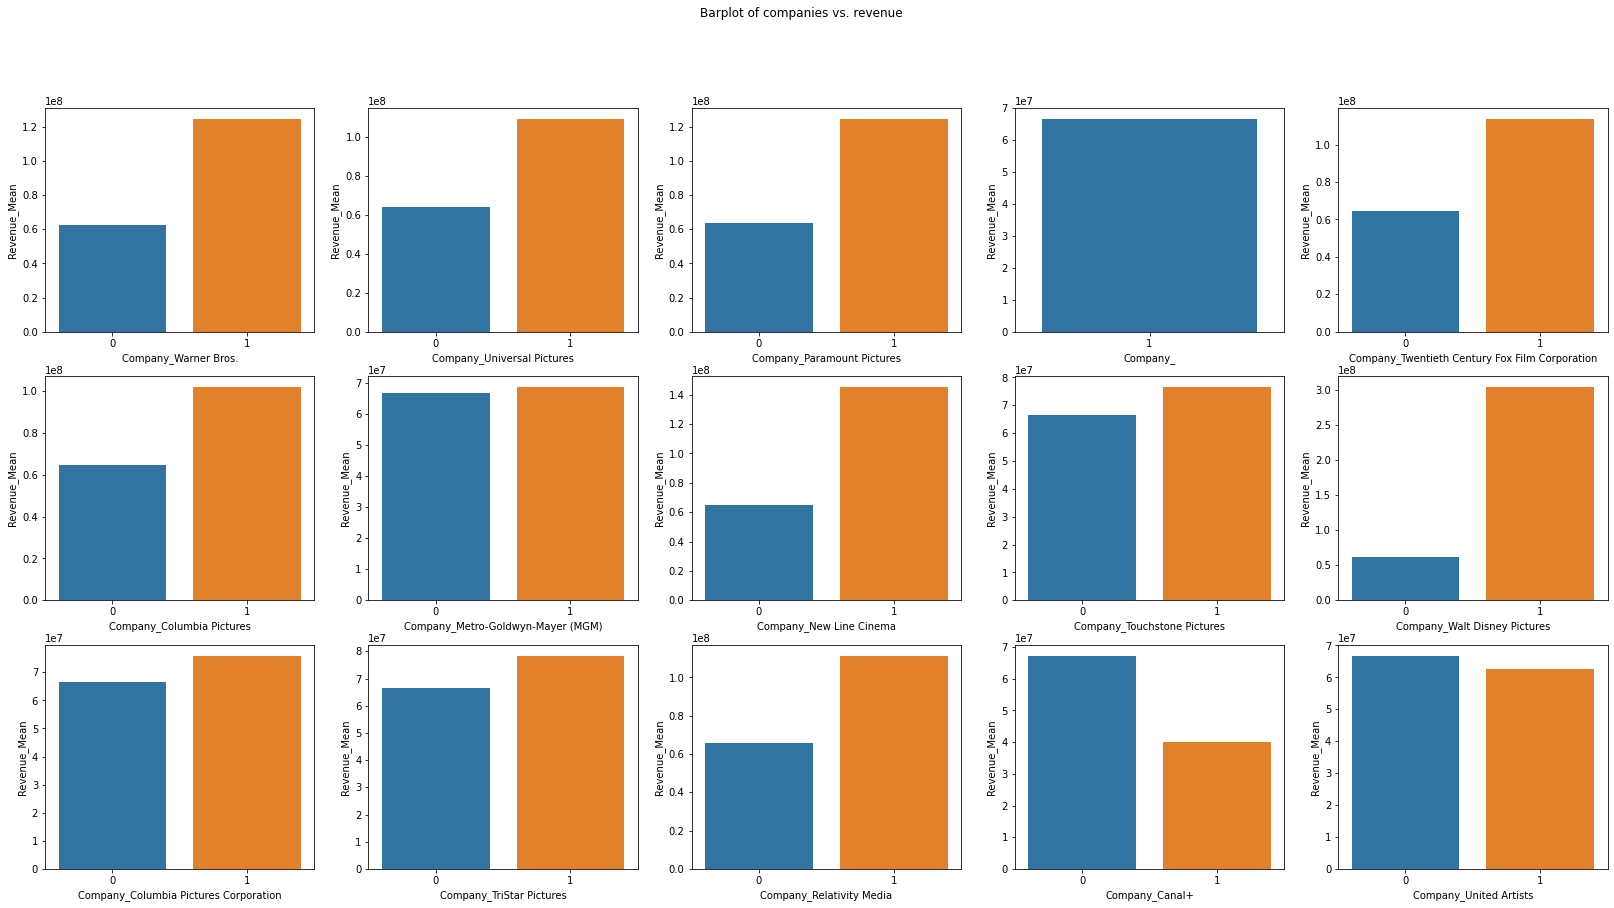

In [660]:
f, axes = plt.subplots(3, 5, figsize=(28, 14))
plt.suptitle('Barplot of companies vs. revenue')
for i, e in enumerate(Companies):
    Gr=train.groupby([e],as_index=False)['revenue'].mean()
    Gr.rename(columns={'revenue':'Revenue_Mean'},inplace=True)
    sns.barplot(data=Gr, x=e, y = "Revenue_Mean", ax=axes[i //5 ][i % 5 ])

**Production Countries**

In [661]:
Countries=['Country_United States of America','Country_United Kingdom','Country_France','Country_Germany','Country_Canada','Country_India','Country_Italy','Country_Japan','Country_Australia','Country_Russia','Country_Spain','Country_China','Country_Hong Kong','Country_Ireland','Country_']

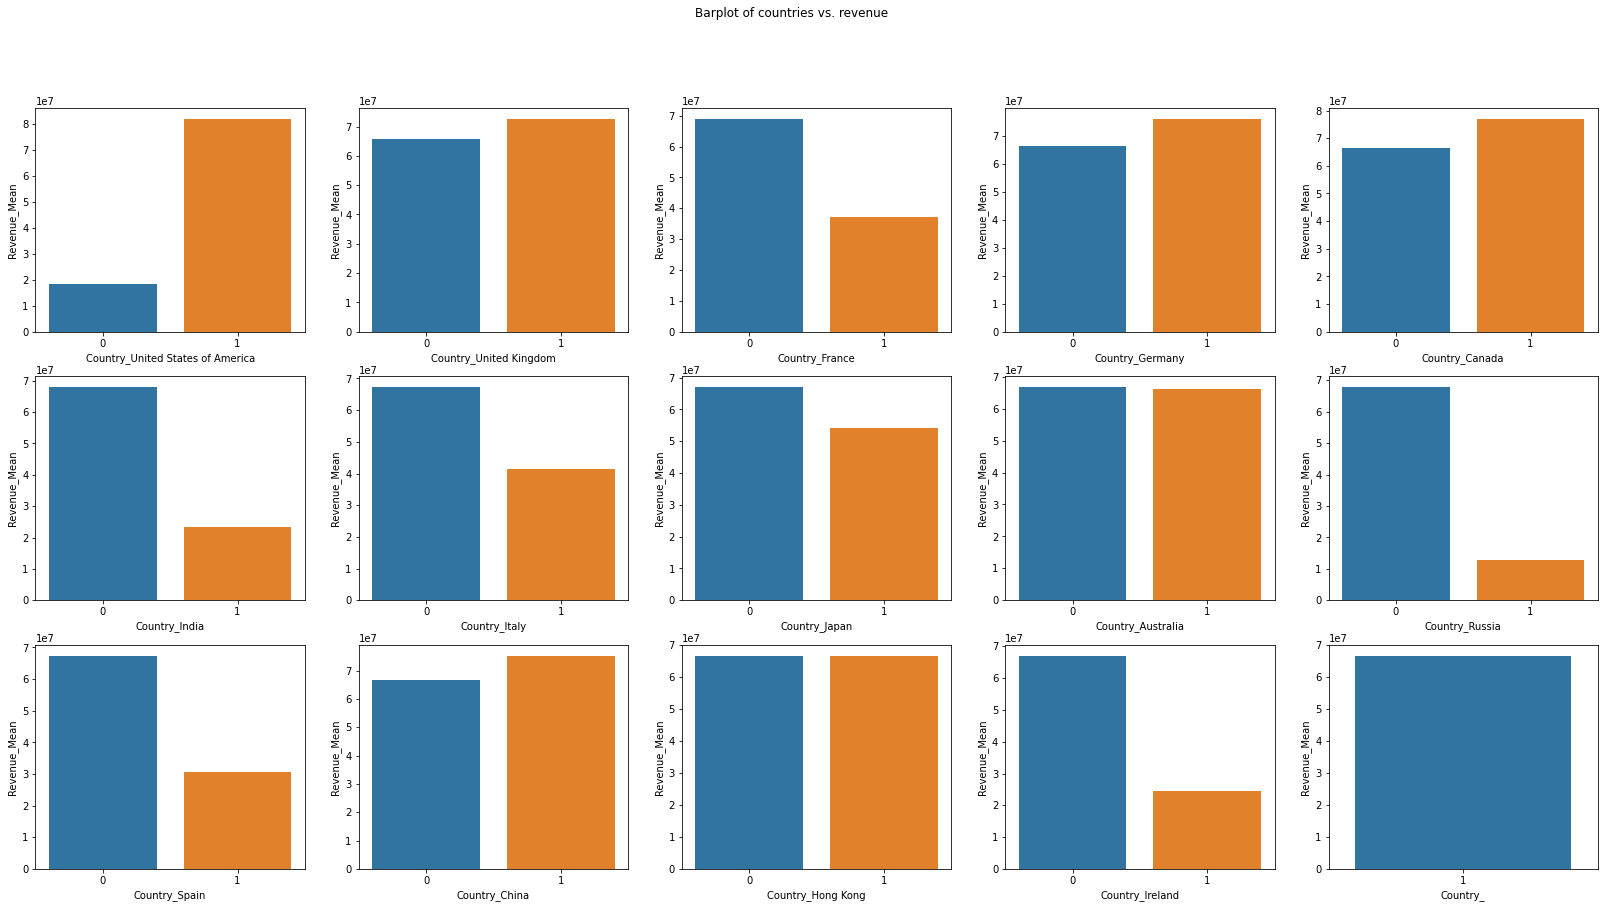

In [662]:
f, axes = plt.subplots(3, 5, figsize=(28, 14))
plt.suptitle('Barplot of countries vs. revenue')
for i, e in enumerate(Countries):
    Gr=train.groupby([e],as_index=False)['revenue'].mean()
    Gr.rename(columns={'revenue':'Revenue_Mean'},inplace=True)
    sns.barplot(data=Gr, x=e, y = "Revenue_Mean", ax=axes[i //5 ][i % 5 ])

#### Number of Spoken Languages

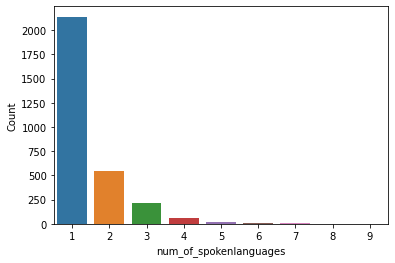

In [663]:
SL=train.groupby(['num_of_spokenlanguages'],as_index=False)['id'].count()
SL.rename(columns={'id':'Count'},inplace=True)
sns.barplot(data=SL, x='num_of_spokenlanguages', y = "Count")

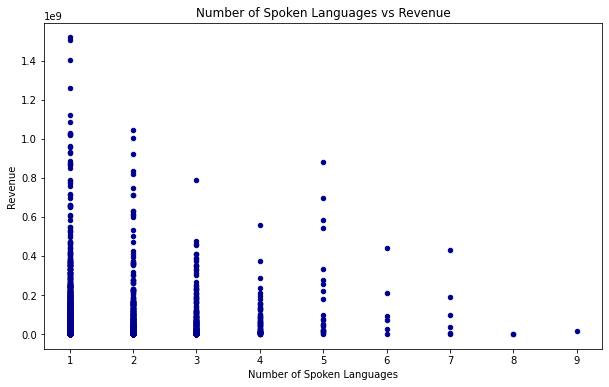

In [664]:
train.plot(kind='scatter', x='num_of_spokenlanguages', y='revenue', figsize=(10, 6), color='darkblue')

plt.title('Number of Spoken Languages vs Revenue')
plt.xlabel('Number of Spoken Languages')
plt.ylabel('Revenue')

plt.show()

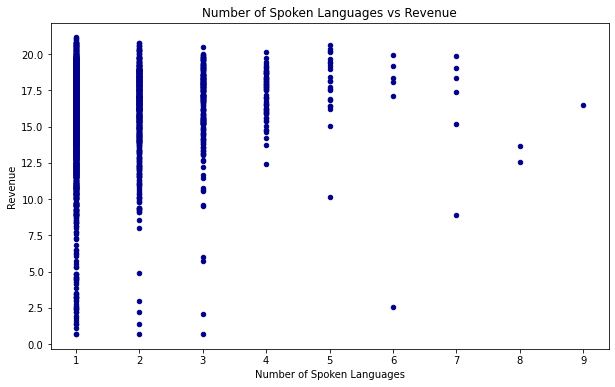

In [665]:
train.plot(kind='scatter', x='num_of_spokenlanguages', y='log_revenue', figsize=(10, 6), color='darkblue')

plt.title('Number of Spoken Languages vs Revenue')
plt.xlabel('Number of Spoken Languages')
plt.ylabel('Revenue')

plt.show()

In [666]:
Spoken_Languages=['Language_English','Language_Français','Language_Español','Language_Deutsch','Language_Pусский','Language_Italiano','Language_日本語','Language_普通话','Language_हिन्दी','Language_Português','Language_العربية','Language_한국어/조선말','Language_广州话 / 廣州話','Language_','Language_தமிழ்']

In [667]:
#f, axes = plt.subplots(3, 5, figsize=(28, 14))
#plt.suptitle('Barplot of spoken languages vs. revenue')
#for i, e in enumerate(Spoken_Languages):
    #Gr=train.groupby([e],as_index=False)['revenue'].mean()
    #Gr.rename(columns={'revenue':'Revenue_Mean'},inplace=True)
    #sns.barplot(data=Gr, x=e, y = "Revenue_Mean", ax=axes[i //5 ][i % 5 ])

#### Keywords

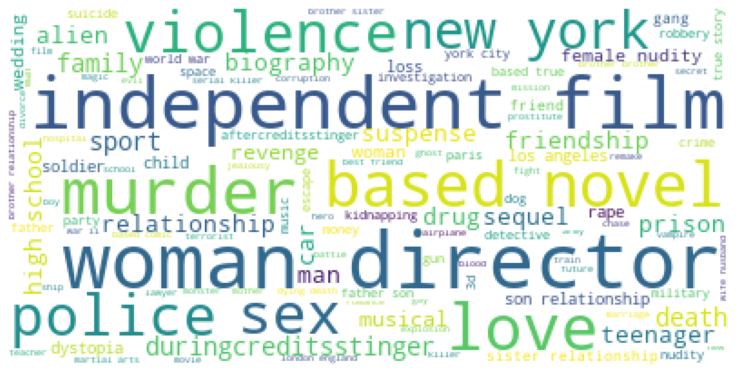

In [668]:
keywords= ' '.join(train['Keywords'].fillna('').values)
plt.figure(figsize =(13,13))
kw_wc = WordCloud(
    background_color='white',
    max_words=500,
    stopwords=stopwords
)

# generate the word cloud
kw_wc.generate(keywords)
plt.imshow(kw_wc)
plt.axis('off')
plt.show()

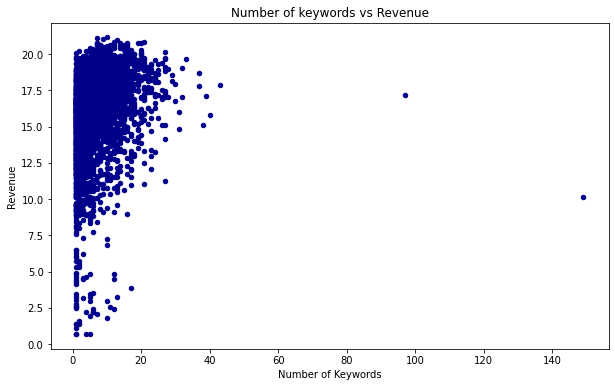

In [669]:
train.plot(kind='scatter', x='num_of_keywords', y='log_revenue', figsize=(10, 6), color='darkblue')

plt.title('Number of keywords vs Revenue')
plt.xlabel('Number of Keywords')
plt.ylabel('Revenue')

plt.show()

#### Runtime

In [670]:
avg_runtime = train['runtime'].astype('float').mean(axis=0)
train['runtime'].replace(np.nan, avg_runtime, inplace=True)

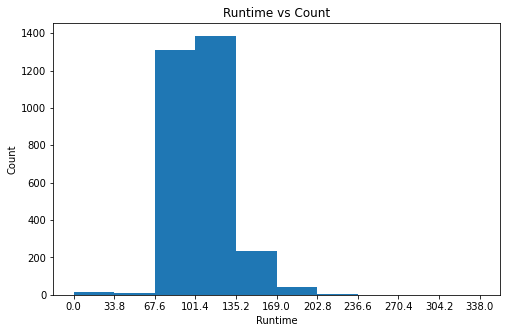

In [671]:
count, bin_edges = np.histogram(train['runtime'])

train['runtime'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges)
plt.title("Runtime vs Count")
plt.xlabel("Runtime")
plt.ylabel("Count")

plt.show()

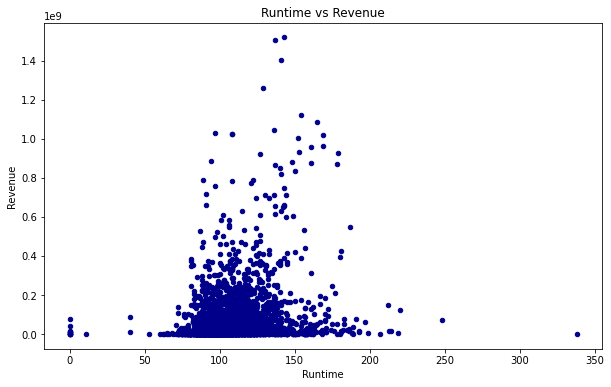

In [672]:
train.plot(kind='scatter', x='runtime', y='revenue', figsize=(10, 6), color='darkblue')

plt.title('Runtime vs Revenue')
plt.xlabel('Runtime')
plt.ylabel('Revenue')

plt.show()

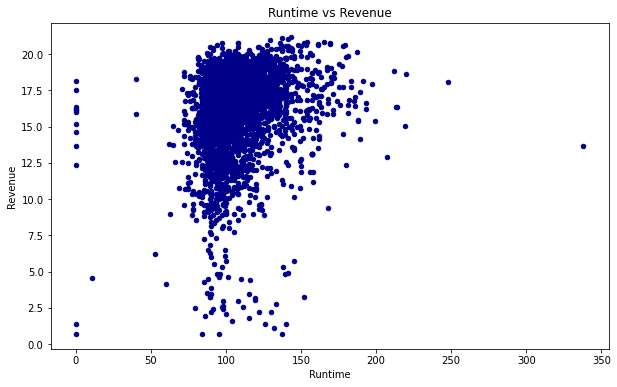

In [673]:
train.plot(kind='scatter', x='runtime', y='log_revenue', figsize=(10, 6), color='darkblue')

plt.title('Runtime vs Revenue')
plt.xlabel('Runtime')
plt.ylabel('Revenue')

plt.show()

#### Status

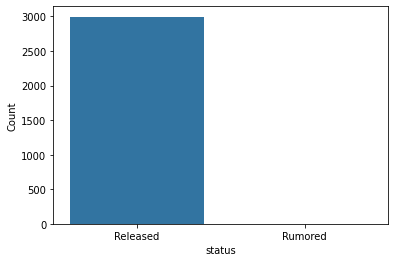

In [674]:
ST=train.groupby(['status'],as_index=False)['id'].count()
ST.rename(columns={'id':'Count'},inplace=True)
sns.barplot(data=ST, x='status', y = "Count")

#### Cast Members

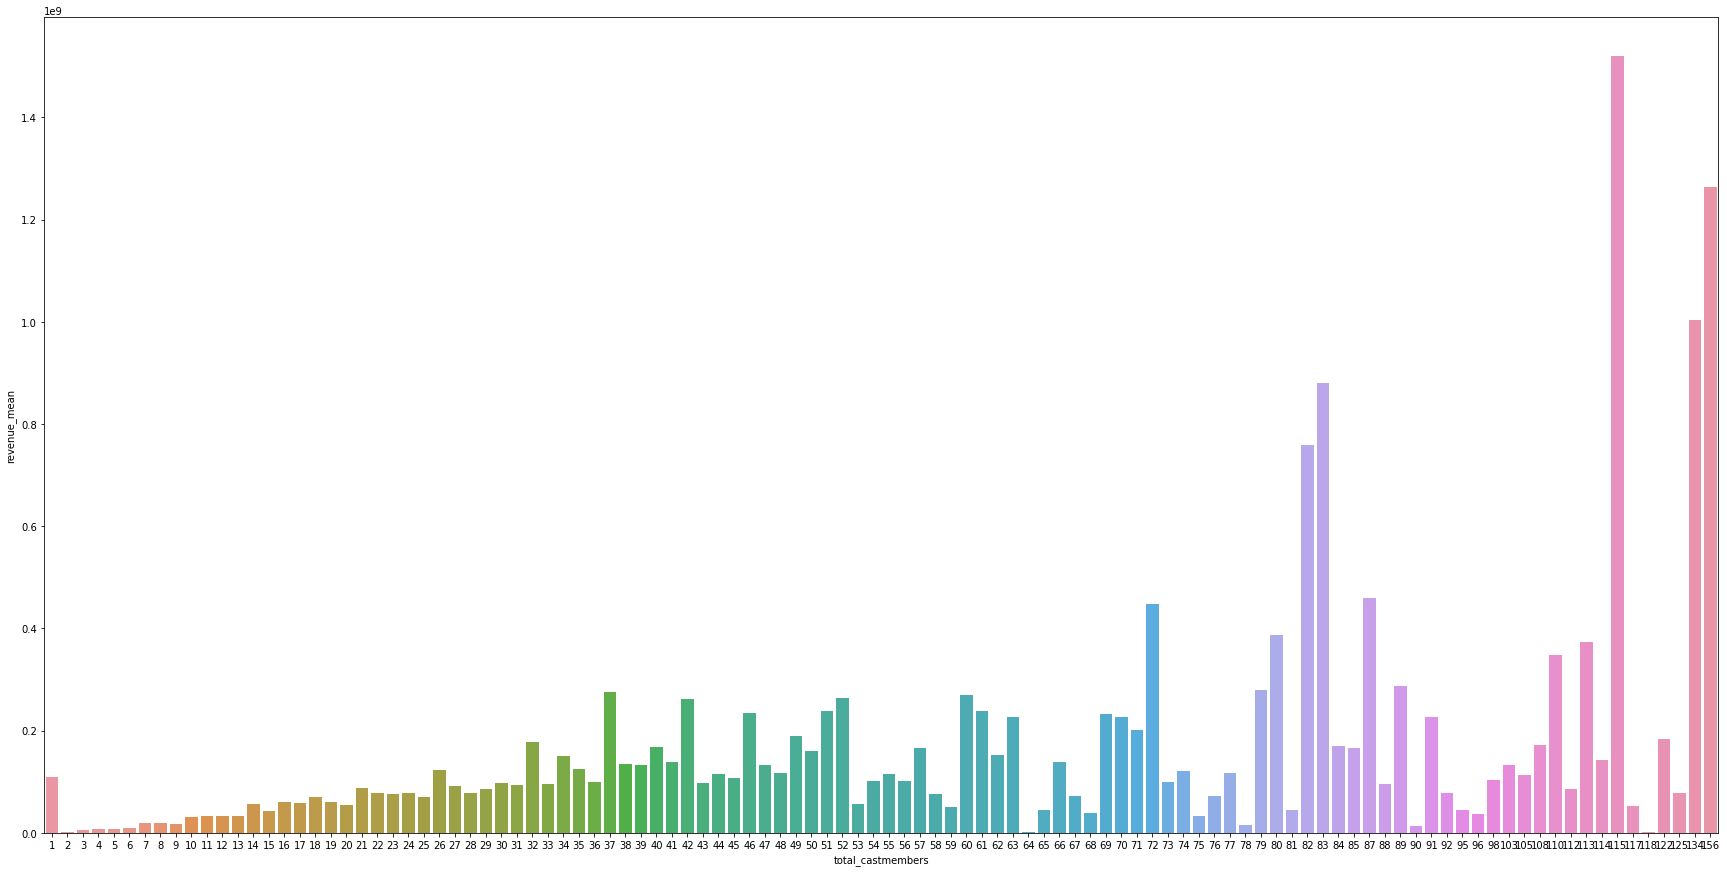

In [675]:
plt.figure(figsize=(30,15))
CM=train.groupby(['total_castmembers'],as_index=False)['revenue'].mean()
CM.rename(columns={'revenue':'revenue_mean'},inplace=True)
sns.barplot(data=CM, x='total_castmembers', y = "revenue_mean")

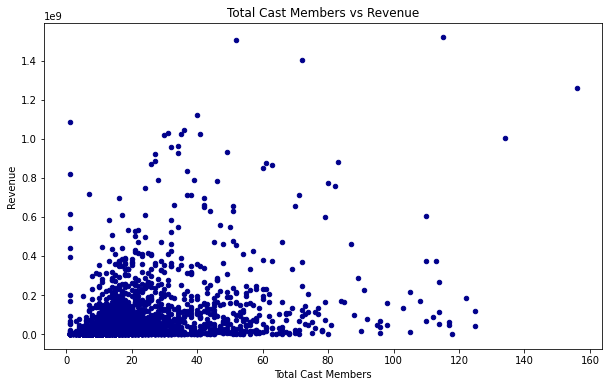

In [676]:
train.plot(kind='scatter', x='total_castmembers', y='revenue', figsize=(10, 6), color='darkblue')

plt.title('Total Cast Members vs Revenue')
plt.xlabel('Total Cast Members')
plt.ylabel('Revenue')

plt.show()

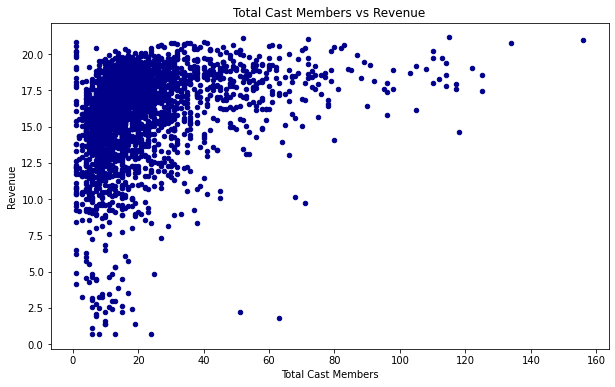

In [677]:
train.plot(kind='scatter', x='total_castmembers', y='log_revenue', figsize=(10, 6), color='darkblue')

plt.title('Total Cast Members vs Revenue')
plt.xlabel('Total Cast Members')
plt.ylabel('Revenue')

plt.show()

#### Total Number of Crew

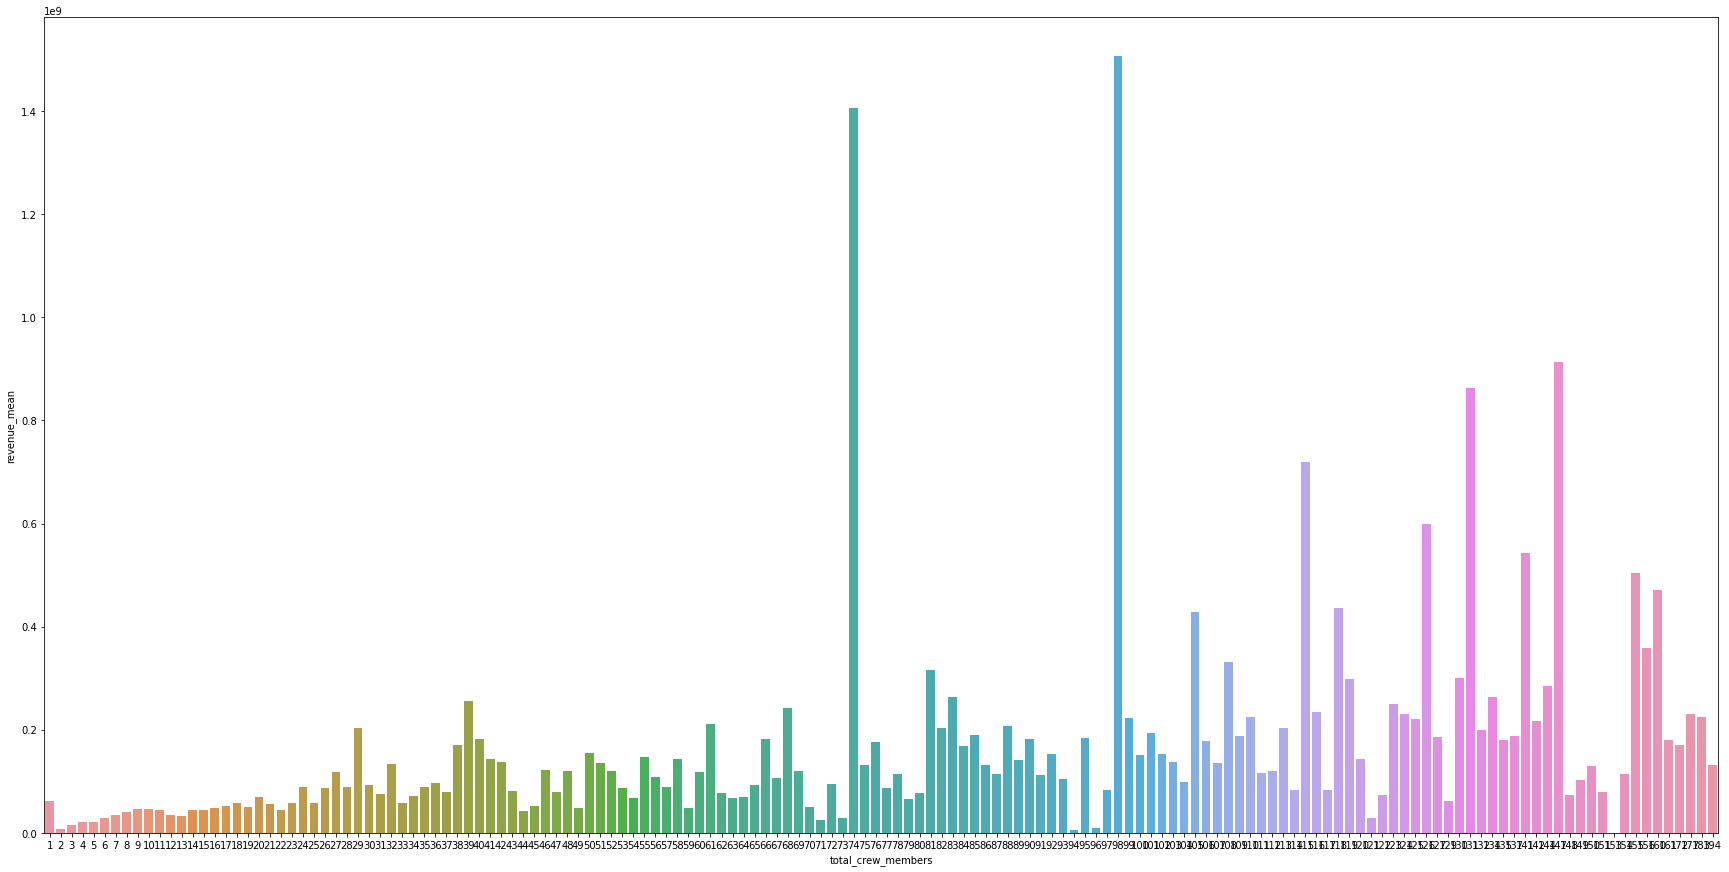

In [678]:
plt.figure(figsize=(30,15))
CM=train.groupby(['total_crew_members'],as_index=False)['revenue'].mean()
CM.rename(columns={'revenue':'revenue_mean'},inplace=True)
sns.barplot(data=CM, x='total_crew_members', y = "revenue_mean")

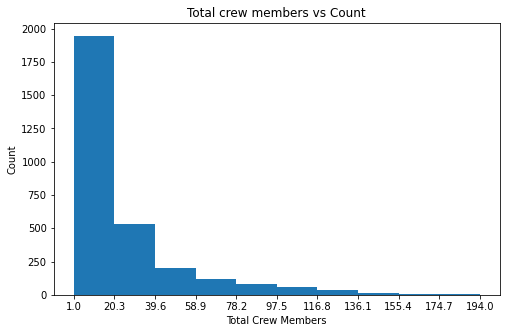

In [679]:
count, bin_edges = np.histogram(train['total_crew_members'])

train['total_crew_members'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges)
plt.title("Total crew members vs Count")
plt.xlabel("Total Crew Members")
plt.ylabel("Count")

plt.show()

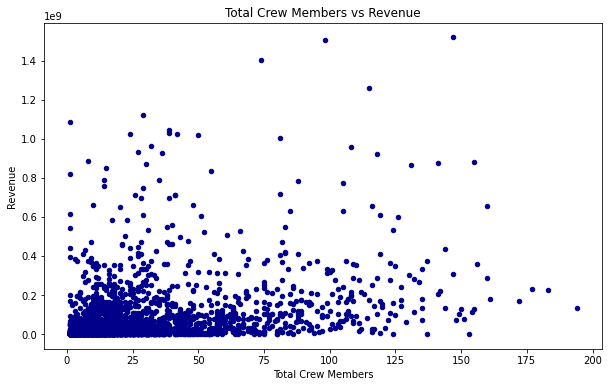

In [680]:
train.plot(kind='scatter', x='total_crew_members', y='revenue', figsize=(10, 6), color='darkblue')

plt.title('Total Crew Members vs Revenue')
plt.xlabel('Total Crew Members')
plt.ylabel('Revenue')

plt.show()

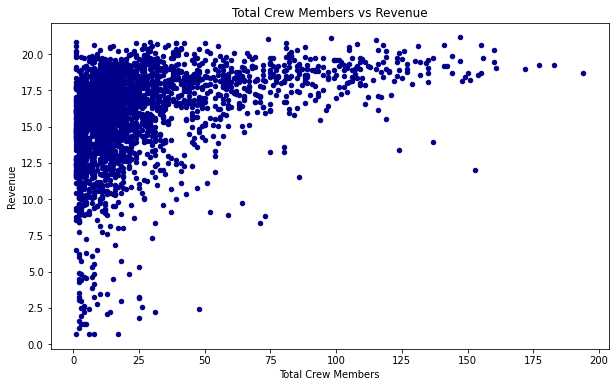

In [681]:
train.plot(kind='scatter', x='total_crew_members', y='log_revenue', figsize=(10, 6), color='darkblue')

plt.title('Total Crew Members vs Revenue')
plt.xlabel('Total Crew Members')
plt.ylabel('Revenue')

plt.show()

In [682]:
train.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity',
       ...
       'Fourth_Quarter_Release', 'len_title', 'words_title', 'len_tagline',
       'words_tagline', 'len_overview', 'words_overview', 'len_original_title',
       'words_original_title', 'log_revenue'],
      dtype='object', length=149)

#### Year

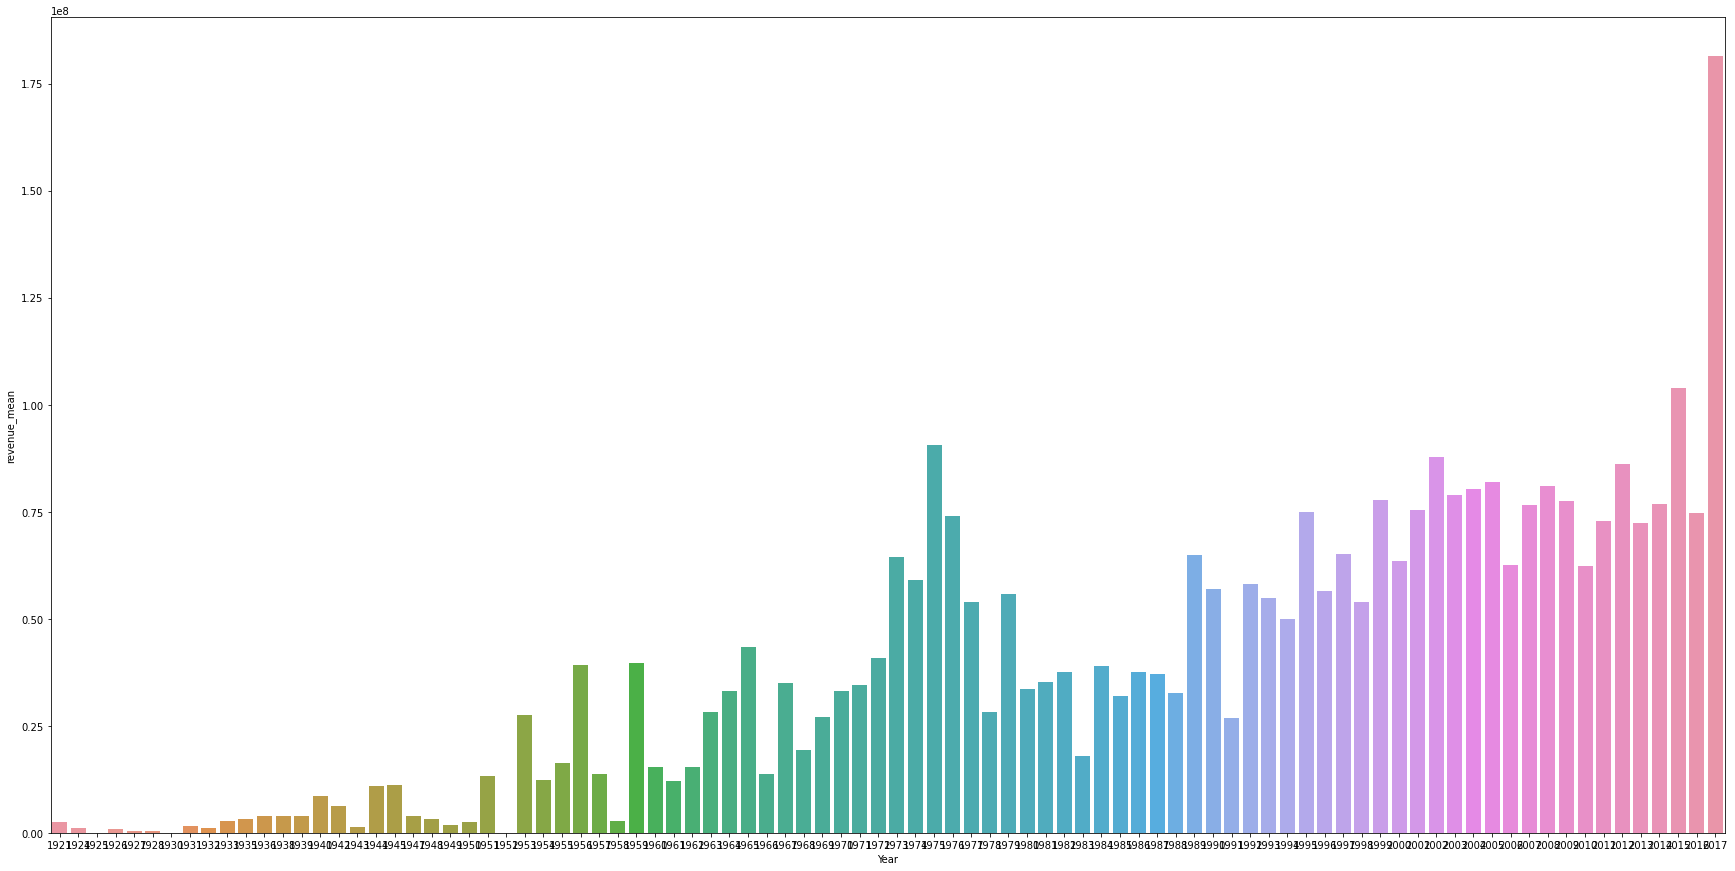

In [683]:
plt.figure(figsize=(30,15))
CM=train.groupby(['Year'],as_index=False)['revenue'].mean()
CM.rename(columns={'revenue':'revenue_mean'},inplace=True)
sns.barplot(data=CM, x='Year', y = "revenue_mean")

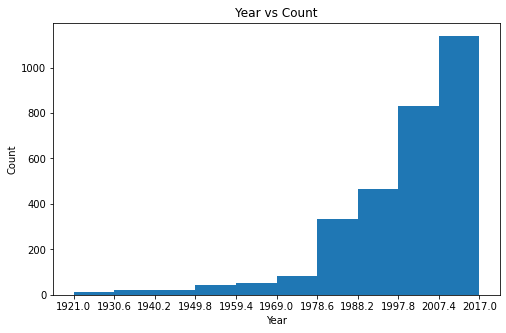

In [684]:
count, bin_edges = np.histogram(train['Year'])

train['Year'].plot(kind='hist', figsize=(8, 5), xticks=bin_edges)
plt.title("Year vs Count")
plt.xlabel("Year")
plt.ylabel("Count")

plt.show()

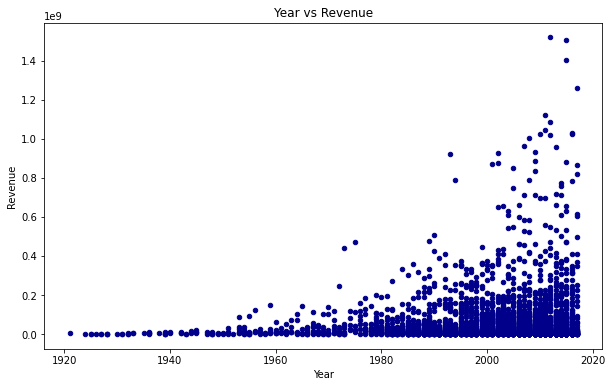

In [685]:
train.plot(kind='scatter', x='Year', y='revenue', figsize=(10, 6), color='darkblue')

plt.title('Year vs Revenue')
plt.xlabel('Year')
plt.ylabel('Revenue')

plt.show()

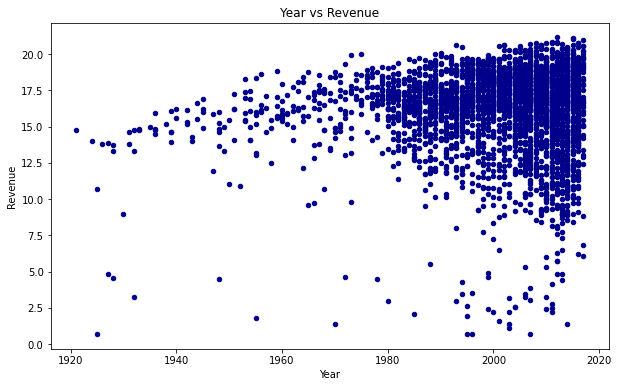

In [686]:
train.plot(kind='scatter', x='Year', y='log_revenue', figsize=(10, 6), color='darkblue')

plt.title('Year vs Revenue')
plt.xlabel('Year')
plt.ylabel('Revenue')

plt.show()

#### Month

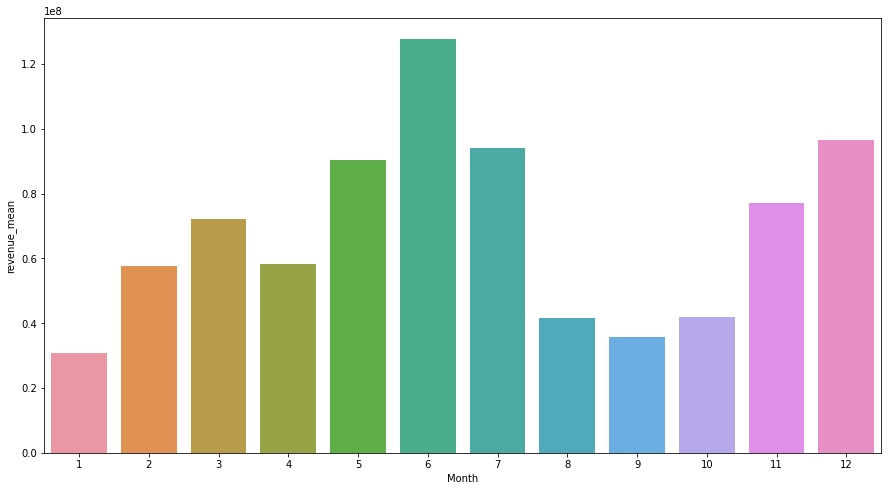

In [687]:
plt.figure(figsize=(15,8))
CM=train.groupby(['Month'],as_index=False)['revenue'].mean()
CM.rename(columns={'revenue':'revenue_mean'},inplace=True)
sns.barplot(data=CM, x='Month', y = "revenue_mean")

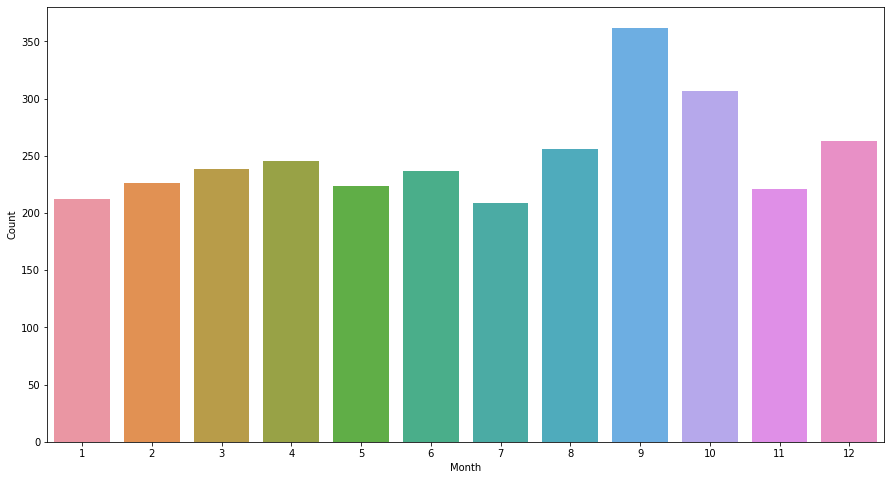

In [688]:
plt.figure(figsize=(15,8))
CM=train.groupby(['Month'],as_index=False)['id'].count()
CM.rename(columns={'id':'Count'},inplace=True)
sns.barplot(data=CM, x='Month', y = "Count")

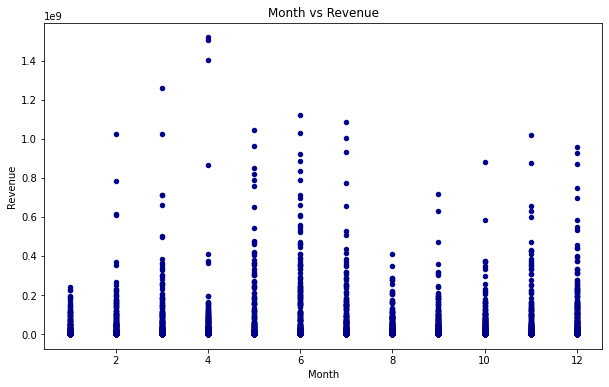

In [689]:
train.plot(kind='scatter', x='Month', y='revenue', figsize=(10, 6), color='darkblue')

plt.title('Month vs Revenue')
plt.xlabel('Month')
plt.ylabel('Revenue')

plt.show()

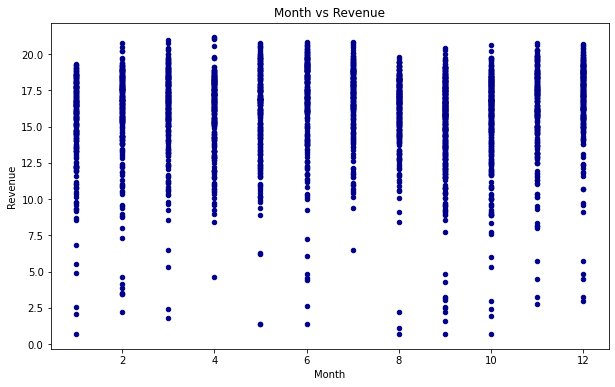

In [690]:
train.plot(kind='scatter', x='Month', y='log_revenue', figsize=(10, 6), color='darkblue')

plt.title('Month vs Revenue')
plt.xlabel('Month')
plt.ylabel('Revenue')

plt.show()

#### Date

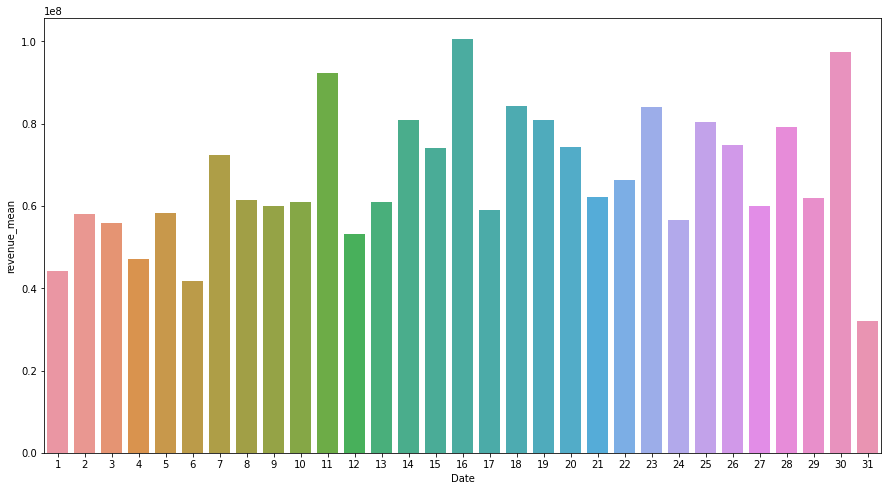

In [691]:
plt.figure(figsize=(15,8))
CM=train.groupby(['Date'],as_index=False)['revenue'].mean()
CM.rename(columns={'revenue':'revenue_mean'},inplace=True)
sns.barplot(data=CM, x='Date', y = "revenue_mean")

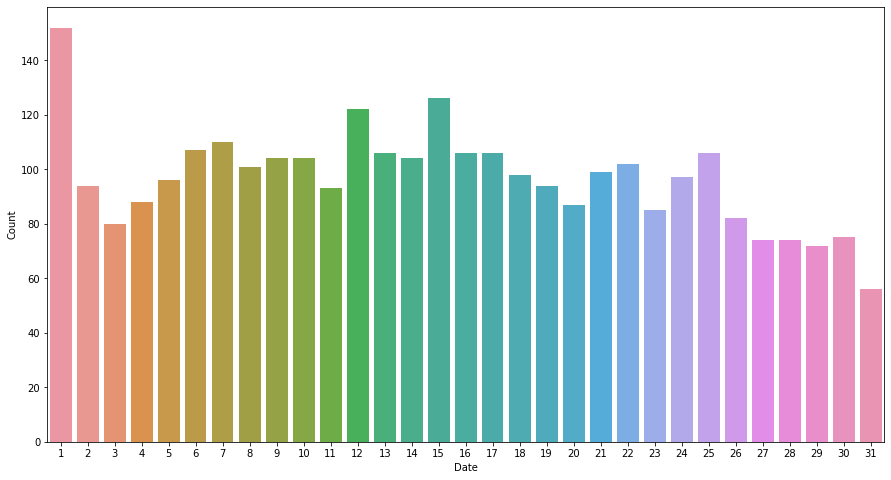

In [692]:
plt.figure(figsize=(15,8))
CM=train.groupby(['Date'],as_index=False)['id'].count()
CM.rename(columns={'id':'Count'},inplace=True)
sns.barplot(data=CM, x='Date', y = "Count")

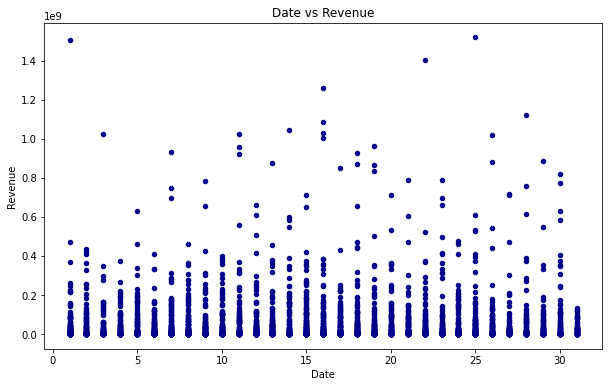

In [693]:
train.plot(kind='scatter', x='Date', y='revenue', figsize=(10, 6), color='darkblue')

plt.title('Date vs Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue')

plt.show()

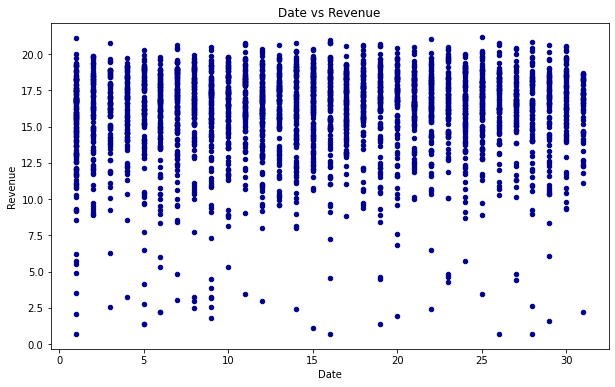

In [694]:
train.plot(kind='scatter', x='Date', y='log_revenue', figsize=(10, 6), color='darkblue')

plt.title('Date vs Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue')

plt.show()

In [695]:
train.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity',
       ...
       'Fourth_Quarter_Release', 'len_title', 'words_title', 'len_tagline',
       'words_tagline', 'len_overview', 'words_overview', 'len_original_title',
       'words_original_title', 'log_revenue'],
      dtype='object', length=149)

#### First Quarter Release

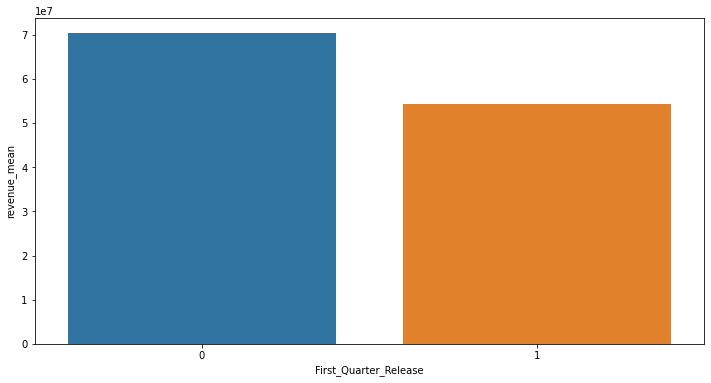

In [696]:
plt.figure(figsize=(12,6))
CM=train.groupby(['First_Quarter_Release'],as_index=False)['revenue'].mean()
CM.rename(columns={'revenue':'revenue_mean'},inplace=True)
sns.barplot(data=CM, x='First_Quarter_Release', y = "revenue_mean")

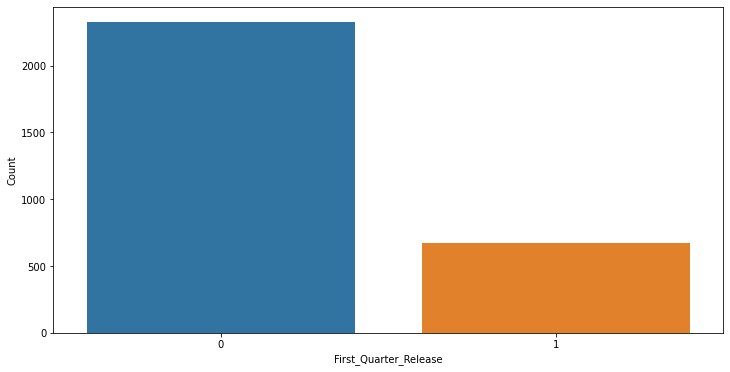

In [697]:
plt.figure(figsize=(12,6))
CM=train.groupby(['First_Quarter_Release'],as_index=False)['id'].count()
CM.rename(columns={'id':'Count'},inplace=True)
sns.barplot(data=CM, x='First_Quarter_Release', y = "Count")

#### Second Quarter Release

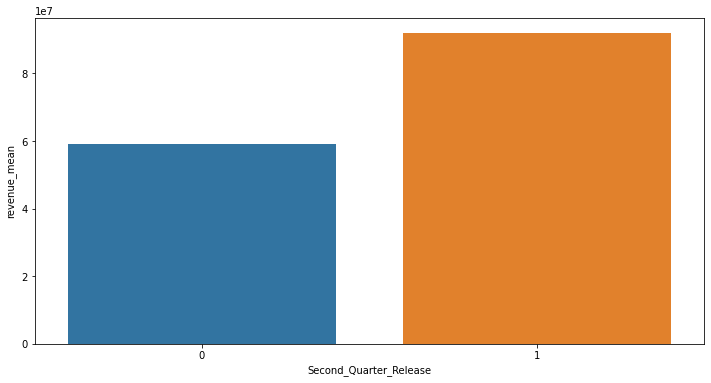

In [698]:
plt.figure(figsize=(12,6))
CM=train.groupby(['Second_Quarter_Release'],as_index=False)['revenue'].mean()
CM.rename(columns={'revenue':'revenue_mean'},inplace=True)
sns.barplot(data=CM, x='Second_Quarter_Release', y = "revenue_mean")

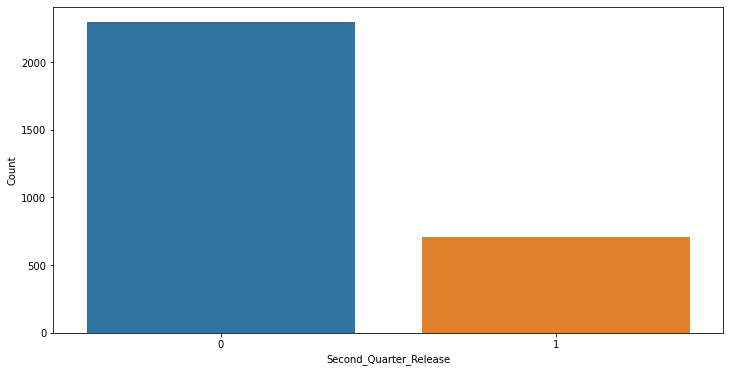

In [699]:
plt.figure(figsize=(12,6))
CM=train.groupby(['Second_Quarter_Release'],as_index=False)['id'].count()
CM.rename(columns={'id':'Count'},inplace=True)
sns.barplot(data=CM, x='Second_Quarter_Release', y = "Count")

#### Third Quarter Release

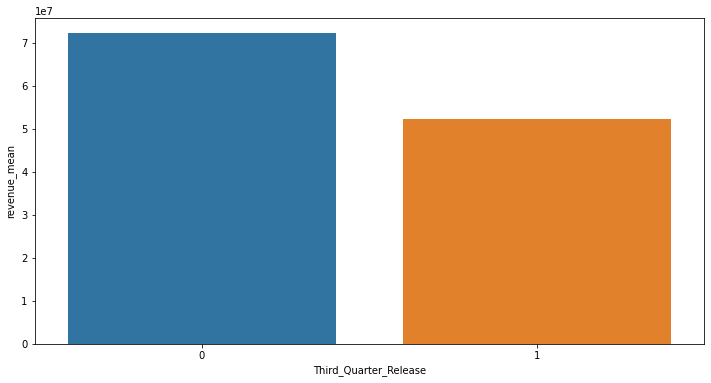

In [700]:
plt.figure(figsize=(12,6))
CM=train.groupby(['Third_Quarter_Release'],as_index=False)['revenue'].mean()
CM.rename(columns={'revenue':'revenue_mean'},inplace=True)
sns.barplot(data=CM, x='Third_Quarter_Release', y = "revenue_mean")

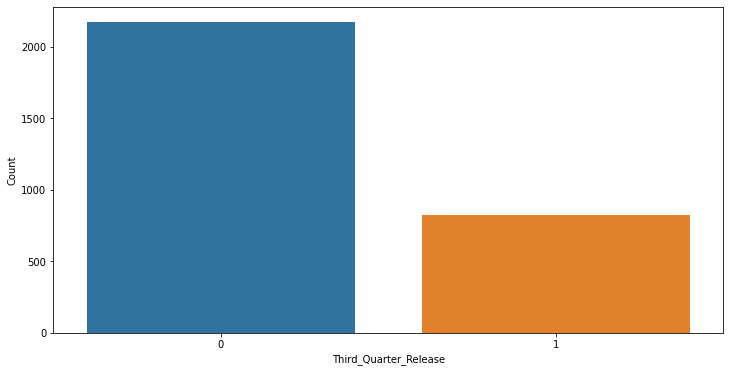

In [701]:
plt.figure(figsize=(12,6))
CM=train.groupby(['Third_Quarter_Release'],as_index=False)['id'].count()
CM.rename(columns={'id':'Count'},inplace=True)
sns.barplot(data=CM, x='Third_Quarter_Release', y = "Count")

#### Fourth Quarter Release

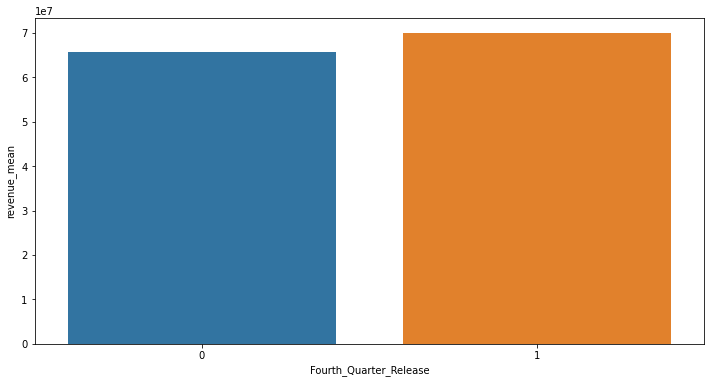

In [702]:
plt.figure(figsize=(12,6))
FOQ=train.groupby(['Fourth_Quarter_Release'],as_index=False)['revenue'].mean()
FOQ.rename(columns={'revenue':'revenue_mean'},inplace=True)
sns.barplot(data=FOQ, x='Fourth_Quarter_Release', y = "revenue_mean")

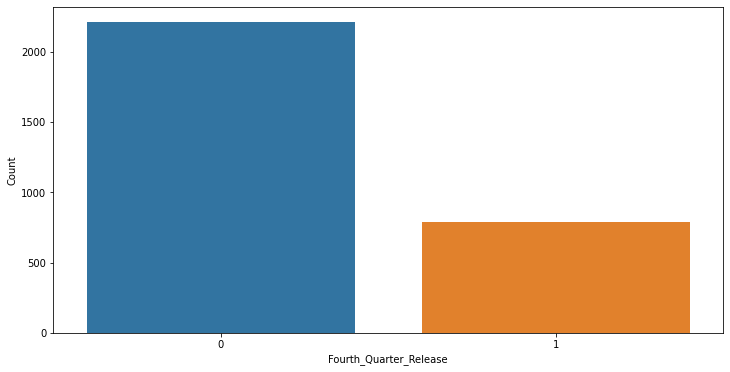

In [703]:
plt.figure(figsize=(12,6))
FOQ=train.groupby(['Fourth_Quarter_Release'],as_index=False)['id'].count()
FOQ.rename(columns={'id':'Count'},inplace=True)
sns.barplot(data=FOQ, x='Fourth_Quarter_Release', y = "Count")

#### Number of production countries

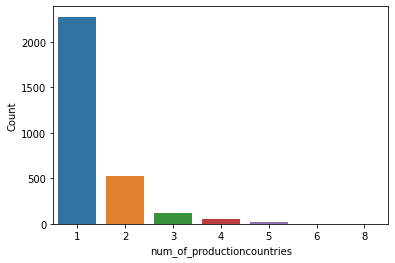

In [704]:
PCO=train.groupby(['num_of_productioncountries'],as_index=False)['id'].count()
PCO.rename(columns={'id':'Count'},inplace=True)
sns.barplot(data=PCO, x='num_of_productioncountries', y = "Count")

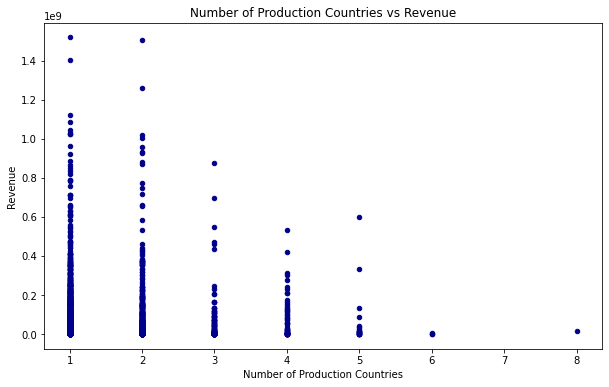

In [705]:
train.plot(kind='scatter', x='num_of_productioncountries', y='revenue', figsize=(10, 6), color='darkblue')

plt.title('Number of Production Countries vs Revenue')
plt.xlabel('Number of Production Countries')
plt.ylabel('Revenue')

plt.show()

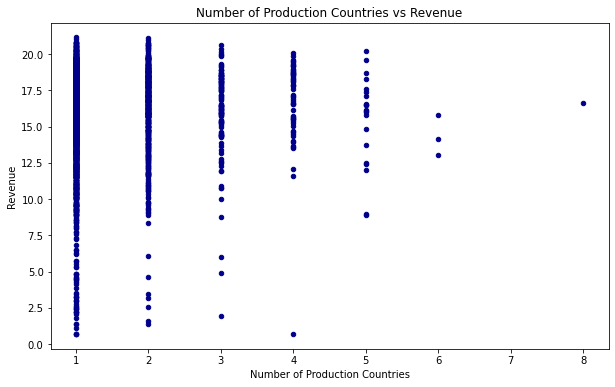

In [706]:
train.plot(kind='scatter', x='num_of_productioncountries', y='log_revenue', figsize=(10, 6), color='darkblue')

plt.title('Number of Production Countries vs Revenue')
plt.xlabel('Number of Production Countries')
plt.ylabel('Revenue')

plt.show()

## Model Fitting

In [707]:
train.shape,test.shape

((3000, 149), (4397, 147))

In [582]:
#list(train.columns.values.tolist()) 

In [708]:
# Converting big budget values into smaller values by taking log
train['log_budget']=np.log1p(train['budget'])

In [709]:
#Dropping the unnecessary columns
X=train.drop(['id','genres','imdb_id','original_language','original_title','overview','poster_path','production_companies','production_countries','release_date','spoken_languages','status', 'tagline', 'title', 'Keywords', 'cast', 'crew','revenue','crew_members','crew_department','crew_job','log_revenue','budget','Country_','Company_','Language_','Keyword_'],axis=1)
Y= train['log_revenue']
test['log_budget']=np.log1p(test['budget'])
test.drop(['id','genres','imdb_id','original_language','original_title','overview','poster_path','production_companies','production_countries','release_date','spoken_languages','status', 'tagline', 'title', 'Keywords', 'cast', 'crew','budget','crew_members','crew_department','crew_job','Country_','Company_','Language_','Keyword_'],axis=1,inplace =True)

In [711]:
X.shape,test.shape

((3000, 123), (4397, 123))

In [712]:
#Splitting the dataset into train and test set
train_X,test_X,train_Y,test_Y=train_test_split(X,Y,random_state=1,test_size=0.2)


### Gradient Boosting with Scikit Learn

In [713]:
from numpy import mean
from numpy import std
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

# evaluate the model
model = GradientBoostingRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
model = GradientBoostingRegressor()
model.fit(train_X,train_Y )


MAE: -1.373 (0.098)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [731]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
mse = mean_squared_error(test_Y, model.predict(test_X))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
rmse = mean_squared_error(test_Y, model.predict(test_X),squared=False)
print("The root mean squared error (RMSE) on test set: {:.4f}".format(rmse))
r2 = r2_score(test_Y, model.predict(test_X))
print("The R2  on test set: {:.4f}".format(r2))

The mean squared error (MSE) on test set: 3.7426
The root mean squared error (RMSE) on test set: 1.9346
The R2  on test set: 0.5328


### Gradient boosting with XGBOOST

In [742]:
import xgboost as xgb

In [755]:
from numpy import mean
from numpy import std
from numpy import asarray
from xgboost import XGBRegressor
# evaluate the model
modelXGB = XGBRegressor(objective='reg:squarederror')
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(modelXGB, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
modelXGB = XGBRegressor()


In [ ]:
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(6,11)],
'colsample_bytree':[i/10.0 for i in range(6,11)], 'max_depth': [2,3,4]}
grid = GridSearchCV(modelXGB, params)
grid.fit(train_X, train_Y)

In [757]:
best_model=grid.best_estimator_

In [758]:
msexgb = mean_squared_error(test_Y, best_model.predict(test_X))
print("The mean squared error (MSE) on test set: {:.4f}".format(msexgb))
rmsexgb = mean_squared_error(test_Y, best_model.predict(test_X),squared= False)
print("The root mean squared error (RMSE) on test set: {:.4f}".format(rmsexgb))
r2 = r2_score(test_Y, best_model.predict(test_X))
print("The R2  on test set: {:.4f}".format(r2))

The mean squared error (MSE) on test set: 3.4557
The root mean squared error (RMSE) on test set: 1.8589
The R2  on test set: 0.5686


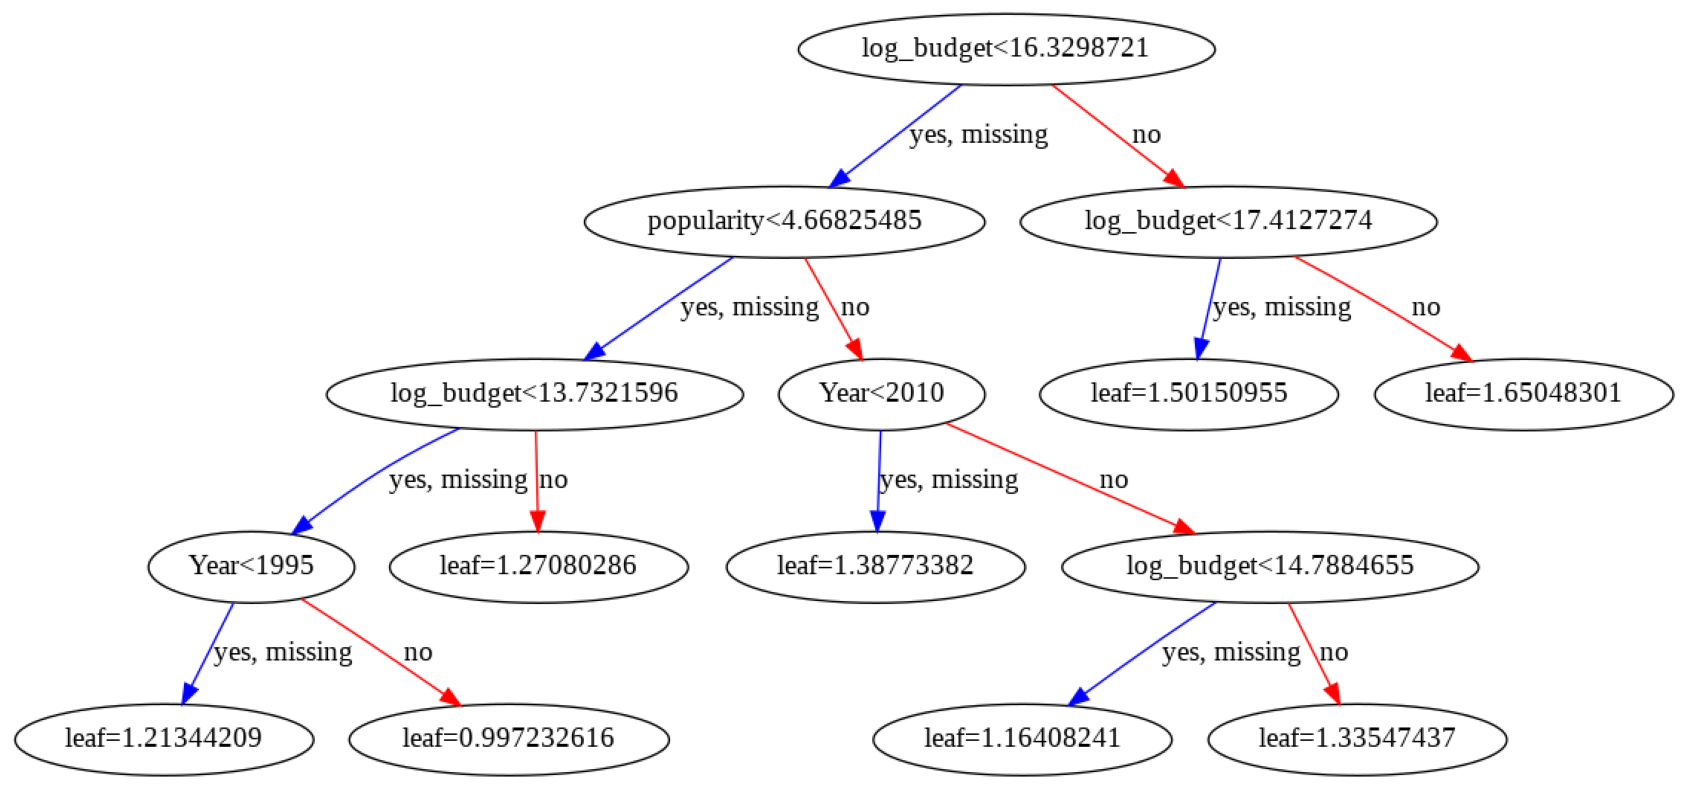

In [780]:
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(best_model, num_trees=1, ax=ax)
plt.show()


**Light GBM**


In [761]:
from lightgbm import LGBMRegressor
modellgbm = LGBMRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(modellgbm, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
modellgbm = LGBMRegressor()

In [ ]:
param_grid = {
        'objective': ['regression'],
        'num_leaves': [15, 23, 31],
        'learning_rate': [0.1, 0.2],
        'n_estimators': [100]}


gs_reg = GridSearchCV(modellgbm, param_grid,
                          n_jobs=1, cv=5,
                          scoring='neg_mean_squared_error')     
gs_reg.fit(train_X, train_Y)

In [765]:
best_lgbm = gs_reg.best_estimator_

In [766]:
mselgbm = mean_squared_error(test_Y, best_lgbm.predict(test_X))
print("The mean squared error (MSE) on test set: {:.4f}".format(mselgbm))
rmselgbm = mean_squared_error(test_Y, best_lgbm.predict(test_X),squared=False)
print("The root mean squared error (RMSE) on test set: {:.4f}".format(rmselgbm))
r2 = r2_score(test_Y, best_lgbm.predict(test_X))
print("The R2  on test set: {:.4f}".format(r2))

The mean squared error (MSE) on test set: 3.6793
The root mean squared error (RMSE) on test set: 1.9182
The R2  on test set: 0.5407


In [ ]:
!pip install shap

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


CPU times: user 337 ms, sys: 5.02 ms, total: 342 ms
Wall time: 347 ms


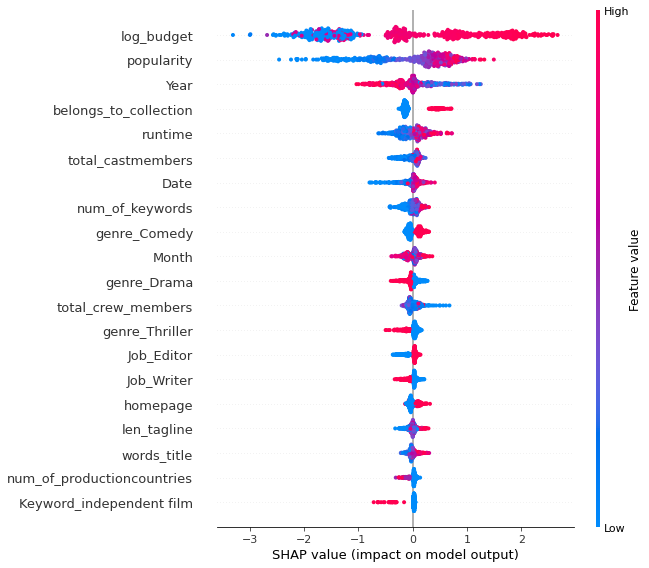

In [784]:
#Trying to explain the results through shap. This is just an intro as I don't have enough knowledge about shap
import shap
%time shap_values = shap.TreeExplainer(best_lgbm).shap_values(test_X)
shap.summary_plot(shap_values, test_X)

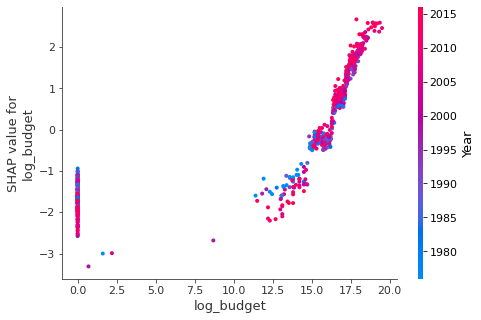

In [785]:
shap.dependence_plot("log_budget", shap_values, test_X)
#Similarly visualize for other features


**Catboost**

In [775]:
#!pip install catboost
from catboost import CatBoostRegressor
modelcat = CatBoostRegressor(verbose=0, n_estimators=100)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(modelcat, X, Y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
# fit the model on the whole dataset
modelcat = CatBoostRegressor(iterations=100000,
                                 learning_rate=0.004,
                                 depth=5,
                                 eval_metric='RMSE',
                                 colsample_bylevel=0.8,
                                 random_seed = random_seed,
                                 bagging_temperature = 0.2,
                                 metric_period = None,
                                 early_stopping_rounds=200
                                )
modelcat.fit(train_X, train_Y,
                 eval_set=(test_X,test_Y),
                 use_best_model=True,
                 verbose=False)

In [776]:
msecat = mean_squared_error(test_Y, modelcat.predict(test_X))
print("The mean squared error (MSE) on test set: {:.4f}".format(msecat))
rmsecat = mean_squared_error(test_Y, modelcat.predict(test_X),squared=False)
print("The root mean squared error (RMSE) on test set: {:.4f}".format(rmsecat))
r2 = r2_score(test_Y, modelcat.predict(test_X))
print("The R2  on test set: {:.4f}".format(r2))

The mean squared error (MSE) on test set: 3.3608
The root mean squared error (RMSE) on test set: 1.8332
The R2  on test set: 0.5804


****Predictions****

In [792]:
#Making predictions on validation set and comparing it with target values
eval=modelcat.predict(test_X)
evaluations=np.expm1(eval)
evaluations1=np.expm1(test_Y)
Evaluations=pd.DataFrame()
Evaluations['revenue']=evaluations
Evaluations['original_revenue']=evaluations1


In [786]:
test.replace(np.nan, 0, inplace=True)

In [787]:
#making predictions on unknown test set
result=modelcat.predict(test)

In [788]:
#Taking back anti log
predictions=np.expm1(result)

In [789]:
predictions

array([ 2252998.1746892 ,  1500403.18969175,  7142031.11196042, ...,
       42177797.56165482,  4386661.32860172,   447882.6499826 ])

In [791]:
Predictions=pd.DataFrame()
Predictions['revenue']=predictions

In [ ]:
Predictions.head()

,revenue
0,1.325163e+06
1,1.502007e+06
2,5.197528e+06
3,6.370743e+06
4,7.698724e+05
